In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/CV/assign2_folder_forsubmission/

Mounted at /content/drive
/content/drive/My Drive/CV/assign2_folder_forsubmission


# Dataloader

In [2]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

batch_size = 32
momentum = 0.9
lr = 0.01
epochs = 10
log_interval = 10

class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Model

# Explanation of the model
---
## Methods used
The model includes two part: 
1. the 4 usual conv layers followed by 2 fully connected layer. 
  

  * CNN feature maps: 3 - 32 - 64 - 128 - 256
  * FCNN parameters: 256 * 4 * 4 - 500 - 43
  * Kernel size: 5, 5, 3, 3
  * Leakey Relu(better performance than relu) as activation function, Batch normalization after each conv layer, dropout layer between (a) CNN block and Linear block (b) 2 linear layer
  * Inspired by the paper about improved lenet-5, instead of adding maxpooling after every CNN layer, only two maxpooling layers are implemented between 2nd layer and 3rd layer and after 4th layer. According to the paper, this design can extract the info of same feature deeper, and it does improve the performance. (My final model is more or less an invariant of the improved lenet-5 model, however, instead of use the same feature numbers for every CNN layer, I found the conventional increasing channels has better performance.)


2. Spatial transformer
  According to the webpage http://torch.ch/blog/2015/09/07/spatial_transformers.html, spatial transformer can increase the performance of the model. The spatial transformer network implemented in my model has feature maps 3 - 8 - 12 - 32, with kernel size 5 and 7

3. Other methods tried but not used
  * Local contrast nomalization. This method is once mentioned in the class but did not enhance the performance

---

## Training
1. Gradient descent

  In my final model I used Stochastic Gradient Descent for training, with $lr = 0.0025$, $momentum = 0.9$.
  * After experiments, small learning rates have better performance. The range is $[0.002, 0.005]$. Generally speaking,  0.003/0.004 has the best performance. However, the best model is trained with $lr=0.0025$
  * I have also tried Adam Gradient Descent, it has no  better performance than the usual stochastic gradient descent
  * I have also tried scheduler to perform learning rate decay. However, it was not benefeciary to my model.

2. Epochs
 Because of the low learning rate used, it generally takes 50-60 epochs to converge. In most of the cases, Models after epoch 60 is overfitted according to the training loss and validation accuracy. However, because of the dropout layer, it is not certain. (Sometimes the model reach the highest validation accuracy around 70 epochs) In practice, I set the epochs to 80 to avoid losing some good models. Epochs after 60m nevertheless, are in most cases a waste of time.

3. Ensemble

  The final model is an ensemble of 3 models during with the best validation accuracy. 

---

## Evaluation 
  My approach got the highest test accuracy of 99.176% (on Kaggle)

  Note that the training output followed is not the traning output of my best model

---
## References
  * The power of Spatial Transformer Networks.  http://torch.ch/blog/2015/09/07/spatial_transformers.html
  * A Lightweight Model for Traffic Sign Classification Based on Enhanced LeNet-5 Network.  https://doi.org/10.1155/2021/8870529
  * Pytorch tutorial for Spatial Transformer Networks. https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html#sphx-glr-intermediate-spatial-transformer-tutorial-py




In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Here is the Improved lenet structure 
        # Basic structure: [conv2d(3, 32), conv(32, 64), conv(64, 128), conv(128, 256)]
        # batch normalization after every conv layer
        # In order to avoid the loss of info during maxpooling, we only do pooling once instead of pooling every layer.
        # Dropout layer between conv block and fc block and between fc layers

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(64)


        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(256*4*4, 500)
        self.fc2 = nn.Linear(500, nclasses)

        # the code of spatatial transformer is largely from pytorch tutorial

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 12, kernel_size=5), # have tried output number : 8, 10(original), 12
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
            )
        
        self.fc_loc = nn.Sequential(
            nn.Linear(12 * 4 * 4, 32), 
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
            )
        
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 12 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x
  

    def forward(self, x):
        x = self.stn(x)
        x = F.leaky_relu(self.conv1(x))
        x = self.bn1(x)
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.bn2(x)

        x = F.leaky_relu(self.conv3(x))
        x = self.bn3(x)
        x = F.leaky_relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = self.bn4(x)

        x = self.conv_drop(x)
        x = x.view(-1, 256*4*4)
        x = F.leaky_relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x,dim=1)


# Training

In [9]:
epochs = 80 # low learning rate used, therefore, more epochs are required
log_interval = 50 

In [10]:
%cd  /content/drive/'My Drive'/CV/assign2_folder_forsubmission/new/

/content/drive/My Drive/CV/assign2_folder_forsubmission/new


In [18]:
val_accuracy_array = []
train_loss_array = []
train_accuracy_array = []

lr = 0.0035
# have tried 0.01, 0.004, 0.003, 0.0025, 0.002, 0,001
momentum = 0.9
batch_size = 32 # redefine it here for conveneince. Have tried: 16, 32, 50, 64

model = Net().cuda()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

#optimizer = optim.Adam(model.parameters(), lr=0.001)
# Have tried Adam, the performance is bad

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,factor=0.5,verbose=True)
# Have tried reduce learning rate automatically, no improvement

def val_train(epoch):
    model.eval()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        train_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    train_loss /= len(train_loader.dataset)
    train_loss_array.append(train_loss)

    train_accuracy = 100. * correct / len(train_loader.dataset)
    train_accuracy_array.append(train_accuracy)

  
    print("\nTrain Epoch:{} Train loss: {:.6f} Train accuracy: {:.6f} %".format(epoch, train_loss, train_accuracy))



def train(epoch):
    total_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
 
        #scheduler.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
        

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)

    val_accuracy_array.append(float(100. * correct / len(val_loader.dataset)))

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    print("Accuracy history last 5", val_accuracy_array[-5:])
    print("Best validation accuracy for now:", max(val_accuracy_array), "%")


for epoch in range(1, epochs + 1):
    train(epoch)
    val_train(epoch)
    validation()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.\n')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.796354
Train Epoch: 1 [1600/35339 (5%)]	Loss: 2.676109
Train Epoch: 1 [3200/35339 (9%)]	Loss: 2.329413
Train Epoch: 1 [4800/35339 (14%)]	Loss: 1.595136
Train Epoch: 1 [6400/35339 (18%)]	Loss: 0.958422
Train Epoch: 1 [8000/35339 (23%)]	Loss: 0.825293
Train Epoch: 1 [9600/35339 (27%)]	Loss: 0.934161
Train Epoch: 1 [11200/35339 (32%)]	Loss: 0.398860
Train Epoch: 1 [12800/35339 (36%)]	Loss: 0.309931
Train Epoch: 1 [14400/35339 (41%)]	Loss: 0.524048
Train Epoch: 1 [16000/35339 (45%)]	Loss: 0.264001
Train Epoch: 1 [17600/35339 (50%)]	Loss: 0.443472
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.075910
Train Epoch: 1 [20800/35339 (59%)]	Loss: 0.168633
Train Epoch: 1 [22400/35339 (63%)]	Loss: 0.361006
Train Epoch: 1 [24000/35339 (68%)]	Loss: 0.190190
Train Epoch: 1 [25600/35339 (72%)]	Loss: 0.209802
Train Epoch: 1 [27200/35339 (77%)]	Loss: 0.163480
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.040015
Train Epoch: 1 [30400/35339 (86%)]	Loss: 0.149775
Train Epoch: 

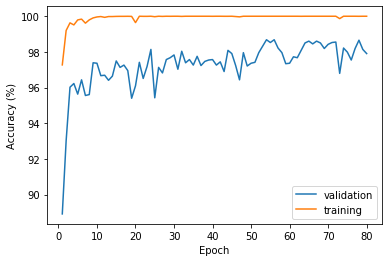

In [35]:
import matplotlib.pyplot as plt
import numpy as np
x = [i+1 for i in range(epochs)]
plt.plot(x, val_accuracy_array, label="validation")
plt.plot(x, train_accuracy_array, label="training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

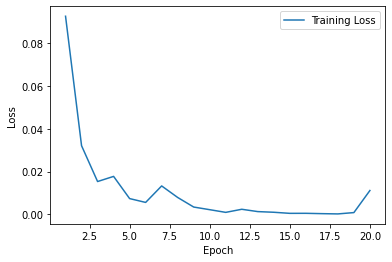

In [38]:
plt.plot(x[:20], train_loss_array[:20], label="Training Loss") # after 20 epoch
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Training serial for best epoch

In [ ]:
"""
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
Train Epoch: 1 [0/35339 (0%)]	Loss: 3.849178
Train Epoch: 1 [1600/35339 (5%)]	Loss: 2.896044
Train Epoch: 1 [3200/35339 (9%)]	Loss: 1.433952
Train Epoch: 1 [4800/35339 (14%)]	Loss: 1.293009
Train Epoch: 1 [6400/35339 (18%)]	Loss: 0.453170
Train Epoch: 1 [8000/35339 (23%)]	Loss: 0.751747
Train Epoch: 1 [9600/35339 (27%)]	Loss: 0.438989
Train Epoch: 1 [11200/35339 (32%)]	Loss: 0.171821
Train Epoch: 1 [12800/35339 (36%)]	Loss: 0.265620
Train Epoch: 1 [14400/35339 (41%)]	Loss: 0.257512
Train Epoch: 1 [16000/35339 (45%)]	Loss: 0.268164
Train Epoch: 1 [17600/35339 (50%)]	Loss: 0.184139
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.123886
Train Epoch: 1 [20800/35339 (59%)]	Loss: 0.051400
Train Epoch: 1 [22400/35339 (63%)]	Loss: 0.124633
Train Epoch: 1 [24000/35339 (68%)]	Loss: 0.483084
Train Epoch: 1 [25600/35339 (72%)]	Loss: 0.142075
Train Epoch: 1 [27200/35339 (77%)]	Loss: 0.046061
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.096171
Train Epoch: 1 [30400/35339 (86%)]	Loss: 0.097000
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.214255
Train Epoch: 1 [33600/35339 (95%)]	Loss: 0.053999
Train Epoch: 1 [35200/35339 (100%)]	Loss: 0.173900

Validation set: Average loss: 0.2368, Accuracy: 3600/3870 (93.02%)

Accuracy history [93.02325439453125]

Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.012685
Train Epoch: 2 [1600/35339 (5%)]	Loss: 0.036541
Train Epoch: 2 [3200/35339 (9%)]	Loss: 0.008516
Train Epoch: 2 [4800/35339 (14%)]	Loss: 0.030233
Train Epoch: 2 [6400/35339 (18%)]	Loss: 0.012172
Train Epoch: 2 [8000/35339 (23%)]	Loss: 0.069649
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.123978
Train Epoch: 2 [11200/35339 (32%)]	Loss: 0.030880
Train Epoch: 2 [12800/35339 (36%)]	Loss: 0.115874
Train Epoch: 2 [14400/35339 (41%)]	Loss: 0.205037
Train Epoch: 2 [16000/35339 (45%)]	Loss: 0.007508
Train Epoch: 2 [17600/35339 (50%)]	Loss: 0.081346
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.056826
Train Epoch: 2 [20800/35339 (59%)]	Loss: 0.142355
Train Epoch: 2 [22400/35339 (63%)]	Loss: 0.076598
Train Epoch: 2 [24000/35339 (68%)]	Loss: 0.091433
Train Epoch: 2 [25600/35339 (72%)]	Loss: 0.056176
Train Epoch: 2 [27200/35339 (77%)]	Loss: 0.051650
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.051219
Train Epoch: 2 [30400/35339 (86%)]	Loss: 0.237203
Train Epoch: 2 [32000/35339 (90%)]	Loss: 0.070197
Train Epoch: 2 [33600/35339 (95%)]	Loss: 0.027284
Train Epoch: 2 [35200/35339 (100%)]	Loss: 0.022542

Validation set: Average loss: 0.2155, Accuracy: 3618/3870 (93.49%)

Accuracy history [93.02325439453125, 93.48837280273438]

Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.018303
Train Epoch: 3 [1600/35339 (5%)]	Loss: 0.025258
Train Epoch: 3 [3200/35339 (9%)]	Loss: 0.026224
Train Epoch: 3 [4800/35339 (14%)]	Loss: 0.040177
Train Epoch: 3 [6400/35339 (18%)]	Loss: 0.015283
Train Epoch: 3 [8000/35339 (23%)]	Loss: 0.005201
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.026204
Train Epoch: 3 [11200/35339 (32%)]	Loss: 0.008969
Train Epoch: 3 [12800/35339 (36%)]	Loss: 0.180913
Train Epoch: 3 [14400/35339 (41%)]	Loss: 0.003396
Train Epoch: 3 [16000/35339 (45%)]	Loss: 0.018566
Train Epoch: 3 [17600/35339 (50%)]	Loss: 0.055407
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.023888
Train Epoch: 3 [20800/35339 (59%)]	Loss: 0.036907
Train Epoch: 3 [22400/35339 (63%)]	Loss: 0.011641
Train Epoch: 3 [24000/35339 (68%)]	Loss: 0.016945
Train Epoch: 3 [25600/35339 (72%)]	Loss: 0.188491
Train Epoch: 3 [27200/35339 (77%)]	Loss: 0.007892
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.084685
Train Epoch: 3 [30400/35339 (86%)]	Loss: 0.004782
Train Epoch: 3 [32000/35339 (90%)]	Loss: 0.000710
Train Epoch: 3 [33600/35339 (95%)]	Loss: 0.027154
Train Epoch: 3 [35200/35339 (100%)]	Loss: 0.001480

Validation set: Average loss: 0.1488, Accuracy: 3707/3870 (95.79%)

Accuracy history [93.02325439453125, 93.48837280273438, 95.78811645507812]

Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.017006
Train Epoch: 4 [1600/35339 (5%)]	Loss: 0.011007
Train Epoch: 4 [3200/35339 (9%)]	Loss: 0.046444
Train Epoch: 4 [4800/35339 (14%)]	Loss: 0.000717
Train Epoch: 4 [6400/35339 (18%)]	Loss: 0.000518
Train Epoch: 4 [8000/35339 (23%)]	Loss: 0.001325
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.007038
Train Epoch: 4 [11200/35339 (32%)]	Loss: 0.003875
Train Epoch: 4 [12800/35339 (36%)]	Loss: 0.004098
Train Epoch: 4 [14400/35339 (41%)]	Loss: 0.000635
Train Epoch: 4 [16000/35339 (45%)]	Loss: 0.004704
Train Epoch: 4 [17600/35339 (50%)]	Loss: 0.002740
Train Epoch: 4 [19200/35339 (54%)]	Loss: 0.238771
Train Epoch: 4 [20800/35339 (59%)]	Loss: 0.002938
Train Epoch: 4 [22400/35339 (63%)]	Loss: 0.003935
Train Epoch: 4 [24000/35339 (68%)]	Loss: 0.001028
Train Epoch: 4 [25600/35339 (72%)]	Loss: 0.000244
Train Epoch: 4 [27200/35339 (77%)]	Loss: 0.006863
Train Epoch: 4 [28800/35339 (81%)]	Loss: 0.002552
Train Epoch: 4 [30400/35339 (86%)]	Loss: 0.075377
Train Epoch: 4 [32000/35339 (90%)]	Loss: 0.003102
Train Epoch: 4 [33600/35339 (95%)]	Loss: 0.070459
Train Epoch: 4 [35200/35339 (100%)]	Loss: 0.050324

Validation set: Average loss: 0.1486, Accuracy: 3687/3870 (95.27%)

Accuracy history [93.02325439453125, 93.48837280273438, 95.78811645507812, 95.27131652832031]

Saved model to model_4.pth.
Train Epoch: 5 [0/35339 (0%)]	Loss: 0.017840
Train Epoch: 5 [1600/35339 (5%)]	Loss: 0.006320
Train Epoch: 5 [3200/35339 (9%)]	Loss: 0.005710
Train Epoch: 5 [4800/35339 (14%)]	Loss: 0.010208
Train Epoch: 5 [6400/35339 (18%)]	Loss: 0.008575
Train Epoch: 5 [8000/35339 (23%)]	Loss: 0.007655
Train Epoch: 5 [9600/35339 (27%)]	Loss: 0.012019
Train Epoch: 5 [11200/35339 (32%)]	Loss: 0.014102
Train Epoch: 5 [12800/35339 (36%)]	Loss: 0.009908
Train Epoch: 5 [14400/35339 (41%)]	Loss: 0.057356
Train Epoch: 5 [16000/35339 (45%)]	Loss: 0.054774
Train Epoch: 5 [17600/35339 (50%)]	Loss: 0.052316
Train Epoch: 5 [19200/35339 (54%)]	Loss: 0.014233
Train Epoch: 5 [20800/35339 (59%)]	Loss: 0.001389
Train Epoch: 5 [22400/35339 (63%)]	Loss: 0.202418
Train Epoch: 5 [24000/35339 (68%)]	Loss: 0.167559
Train Epoch: 5 [25600/35339 (72%)]	Loss: 0.015650
Train Epoch: 5 [27200/35339 (77%)]	Loss: 0.024117
Train Epoch: 5 [28800/35339 (81%)]	Loss: 0.001864
Train Epoch: 5 [30400/35339 (86%)]	Loss: 0.018431
Train Epoch: 5 [32000/35339 (90%)]	Loss: 0.002186
Train Epoch: 5 [33600/35339 (95%)]	Loss: 0.001370
Train Epoch: 5 [35200/35339 (100%)]	Loss: 0.001283

Validation set: Average loss: 0.1371, Accuracy: 3709/3870 (95.84%)

Accuracy history [93.02325439453125, 93.48837280273438, 95.78811645507812, 95.27131652832031, 95.83979034423828]

Saved model to model_5.pth.
Train Epoch: 6 [0/35339 (0%)]	Loss: 0.000969
Train Epoch: 6 [1600/35339 (5%)]	Loss: 0.026385
Train Epoch: 6 [3200/35339 (9%)]	Loss: 0.009754
Train Epoch: 6 [4800/35339 (14%)]	Loss: 0.031992
Train Epoch: 6 [6400/35339 (18%)]	Loss: 0.005128
Train Epoch: 6 [8000/35339 (23%)]	Loss: 0.006517
Train Epoch: 6 [9600/35339 (27%)]	Loss: 0.033350
Train Epoch: 6 [11200/35339 (32%)]	Loss: 0.028847
Train Epoch: 6 [12800/35339 (36%)]	Loss: 0.048355
Train Epoch: 6 [14400/35339 (41%)]	Loss: 0.000976
Train Epoch: 6 [16000/35339 (45%)]	Loss: 0.022790
Train Epoch: 6 [17600/35339 (50%)]	Loss: 0.001963
Train Epoch: 6 [19200/35339 (54%)]	Loss: 0.041303
Train Epoch: 6 [20800/35339 (59%)]	Loss: 0.030074
Train Epoch: 6 [22400/35339 (63%)]	Loss: 0.000922
Train Epoch: 6 [24000/35339 (68%)]	Loss: 0.028068
Train Epoch: 6 [25600/35339 (72%)]	Loss: 0.046896
Train Epoch: 6 [27200/35339 (77%)]	Loss: 0.000840
Train Epoch: 6 [28800/35339 (81%)]	Loss: 0.006505
Train Epoch: 6 [30400/35339 (86%)]	Loss: 0.028676
Train Epoch: 6 [32000/35339 (90%)]	Loss: 0.004917
Train Epoch: 6 [33600/35339 (95%)]	Loss: 0.000273
Train Epoch: 6 [35200/35339 (100%)]	Loss: 0.176571

Validation set: Average loss: 0.2224, Accuracy: 3624/3870 (93.64%)

Accuracy history [93.48837280273438, 95.78811645507812, 95.27131652832031, 95.83979034423828, 93.6434097290039]

Saved model to model_6.pth.
Train Epoch: 7 [0/35339 (0%)]	Loss: 0.001215
Train Epoch: 7 [1600/35339 (5%)]	Loss: 0.004795
Train Epoch: 7 [3200/35339 (9%)]	Loss: 0.003364
Train Epoch: 7 [4800/35339 (14%)]	Loss: 0.018935
Train Epoch: 7 [6400/35339 (18%)]	Loss: 0.014177
Train Epoch: 7 [8000/35339 (23%)]	Loss: 0.034128
Train Epoch: 7 [9600/35339 (27%)]	Loss: 0.015395
Train Epoch: 7 [11200/35339 (32%)]	Loss: 0.003724
Train Epoch: 7 [12800/35339 (36%)]	Loss: 0.000508
Train Epoch: 7 [14400/35339 (41%)]	Loss: 0.003418
Train Epoch: 7 [16000/35339 (45%)]	Loss: 0.000419
Train Epoch: 7 [17600/35339 (50%)]	Loss: 0.027310
Train Epoch: 7 [19200/35339 (54%)]	Loss: 0.002152
Train Epoch: 7 [20800/35339 (59%)]	Loss: 0.000186
Train Epoch: 7 [22400/35339 (63%)]	Loss: 0.004174
Train Epoch: 7 [24000/35339 (68%)]	Loss: 0.000979
Train Epoch: 7 [25600/35339 (72%)]	Loss: 0.066691
Train Epoch: 7 [27200/35339 (77%)]	Loss: 0.000573
Train Epoch: 7 [28800/35339 (81%)]	Loss: 0.001206
Train Epoch: 7 [30400/35339 (86%)]	Loss: 0.000206
Train Epoch: 7 [32000/35339 (90%)]	Loss: 0.000220
Train Epoch: 7 [33600/35339 (95%)]	Loss: 0.001436
Train Epoch: 7 [35200/35339 (100%)]	Loss: 0.000426

Validation set: Average loss: 0.1094, Accuracy: 3734/3870 (96.49%)

Accuracy history [95.78811645507812, 95.27131652832031, 95.83979034423828, 93.6434097290039, 96.48578643798828]

Saved model to model_7.pth.
Train Epoch: 8 [0/35339 (0%)]	Loss: 0.000726
Train Epoch: 8 [1600/35339 (5%)]	Loss: 0.001449
Train Epoch: 8 [3200/35339 (9%)]	Loss: 0.000045
Train Epoch: 8 [4800/35339 (14%)]	Loss: 0.004013
Train Epoch: 8 [6400/35339 (18%)]	Loss: 0.002516
Train Epoch: 8 [8000/35339 (23%)]	Loss: 0.040700
Train Epoch: 8 [9600/35339 (27%)]	Loss: 0.003121
Train Epoch: 8 [11200/35339 (32%)]	Loss: 0.004789
Train Epoch: 8 [12800/35339 (36%)]	Loss: 0.006118
Train Epoch: 8 [14400/35339 (41%)]	Loss: 0.016341
Train Epoch: 8 [16000/35339 (45%)]	Loss: 0.000241
Train Epoch: 8 [17600/35339 (50%)]	Loss: 0.000035
Train Epoch: 8 [19200/35339 (54%)]	Loss: 0.000284
Train Epoch: 8 [20800/35339 (59%)]	Loss: 0.000198
Train Epoch: 8 [22400/35339 (63%)]	Loss: 0.020255
Train Epoch: 8 [24000/35339 (68%)]	Loss: 0.008650
Train Epoch: 8 [25600/35339 (72%)]	Loss: 0.001266
Train Epoch: 8 [27200/35339 (77%)]	Loss: 0.000805
Train Epoch: 8 [28800/35339 (81%)]	Loss: 0.001299
Train Epoch: 8 [30400/35339 (86%)]	Loss: 0.003792
Train Epoch: 8 [32000/35339 (90%)]	Loss: 0.001491
Train Epoch: 8 [33600/35339 (95%)]	Loss: 0.000693
Train Epoch: 8 [35200/35339 (100%)]	Loss: 0.002443

Validation set: Average loss: 0.1425, Accuracy: 3708/3870 (95.81%)

Accuracy history [95.27131652832031, 95.83979034423828, 93.6434097290039, 96.48578643798828, 95.81395721435547]

Saved model to model_8.pth.
Train Epoch: 9 [0/35339 (0%)]	Loss: 0.001959
Train Epoch: 9 [1600/35339 (5%)]	Loss: 0.006100
Train Epoch: 9 [3200/35339 (9%)]	Loss: 0.000280
Train Epoch: 9 [4800/35339 (14%)]	Loss: 0.001350
Train Epoch: 9 [6400/35339 (18%)]	Loss: 0.000526
Train Epoch: 9 [8000/35339 (23%)]	Loss: 0.002088
Train Epoch: 9 [9600/35339 (27%)]	Loss: 0.001123
Train Epoch: 9 [11200/35339 (32%)]	Loss: 0.019383
Train Epoch: 9 [12800/35339 (36%)]	Loss: 0.000527
Train Epoch: 9 [14400/35339 (41%)]	Loss: 0.001052
Train Epoch: 9 [16000/35339 (45%)]	Loss: 0.000242
Train Epoch: 9 [17600/35339 (50%)]	Loss: 0.003436
Train Epoch: 9 [19200/35339 (54%)]	Loss: 0.001114
Train Epoch: 9 [20800/35339 (59%)]	Loss: 0.002164
Train Epoch: 9 [22400/35339 (63%)]	Loss: 0.022203
Train Epoch: 9 [24000/35339 (68%)]	Loss: 0.006833
Train Epoch: 9 [25600/35339 (72%)]	Loss: 0.018166
Train Epoch: 9 [27200/35339 (77%)]	Loss: 0.000346
Train Epoch: 9 [28800/35339 (81%)]	Loss: 0.000438
Train Epoch: 9 [30400/35339 (86%)]	Loss: 0.000071
Train Epoch: 9 [32000/35339 (90%)]	Loss: 0.001099
Train Epoch: 9 [33600/35339 (95%)]	Loss: 0.001499
Train Epoch: 9 [35200/35339 (100%)]	Loss: 0.000184

Validation set: Average loss: 0.1001, Accuracy: 3753/3870 (96.98%)

Accuracy history [95.83979034423828, 93.6434097290039, 96.48578643798828, 95.81395721435547, 96.97674560546875]

Saved model to model_9.pth.
Train Epoch: 10 [0/35339 (0%)]	Loss: 0.004678
Train Epoch: 10 [1600/35339 (5%)]	Loss: 0.004574
Train Epoch: 10 [3200/35339 (9%)]	Loss: 0.000601
Train Epoch: 10 [4800/35339 (14%)]	Loss: 0.019897
Train Epoch: 10 [6400/35339 (18%)]	Loss: 0.004670
Train Epoch: 10 [8000/35339 (23%)]	Loss: 0.000040
Train Epoch: 10 [9600/35339 (27%)]	Loss: 0.000252
Train Epoch: 10 [11200/35339 (32%)]	Loss: 0.000697
Train Epoch: 10 [12800/35339 (36%)]	Loss: 0.005377
Train Epoch: 10 [14400/35339 (41%)]	Loss: 0.001905
Train Epoch: 10 [16000/35339 (45%)]	Loss: 0.000832
Train Epoch: 10 [17600/35339 (50%)]	Loss: 0.012335
Train Epoch: 10 [19200/35339 (54%)]	Loss: 0.000521
Train Epoch: 10 [20800/35339 (59%)]	Loss: 0.000306
Train Epoch: 10 [22400/35339 (63%)]	Loss: 0.225908
Train Epoch: 10 [24000/35339 (68%)]	Loss: 0.002642
Train Epoch: 10 [25600/35339 (72%)]	Loss: 0.051197
Train Epoch: 10 [27200/35339 (77%)]	Loss: 0.003004
Train Epoch: 10 [28800/35339 (81%)]	Loss: 0.002527
Train Epoch: 10 [30400/35339 (86%)]	Loss: 0.026072
Train Epoch: 10 [32000/35339 (90%)]	Loss: 0.000324
Train Epoch: 10 [33600/35339 (95%)]	Loss: 0.000244
Train Epoch: 10 [35200/35339 (100%)]	Loss: 0.000088

Validation set: Average loss: 0.1202, Accuracy: 3730/3870 (96.38%)

Accuracy history [93.6434097290039, 96.48578643798828, 95.81395721435547, 96.97674560546875, 96.38243103027344]

Saved model to model_10.pth.
Train Epoch: 11 [0/35339 (0%)]	Loss: 0.064612
Train Epoch: 11 [1600/35339 (5%)]	Loss: 0.000235
Train Epoch: 11 [3200/35339 (9%)]	Loss: 0.002101
Train Epoch: 11 [4800/35339 (14%)]	Loss: 0.000046
Train Epoch: 11 [6400/35339 (18%)]	Loss: 0.000888
Train Epoch: 11 [8000/35339 (23%)]	Loss: 0.000763
Train Epoch: 11 [9600/35339 (27%)]	Loss: 0.003043
Train Epoch: 11 [11200/35339 (32%)]	Loss: 0.001227
Train Epoch: 11 [12800/35339 (36%)]	Loss: 0.001992
Train Epoch: 11 [14400/35339 (41%)]	Loss: 0.021501
Train Epoch: 11 [16000/35339 (45%)]	Loss: 0.008926
Train Epoch: 11 [17600/35339 (50%)]	Loss: 0.001118
Train Epoch: 11 [19200/35339 (54%)]	Loss: 0.000945
Train Epoch: 11 [20800/35339 (59%)]	Loss: 0.003367
Train Epoch: 11 [22400/35339 (63%)]	Loss: 0.000246
Train Epoch: 11 [24000/35339 (68%)]	Loss: 0.000971
Train Epoch: 11 [25600/35339 (72%)]	Loss: 0.001848
Train Epoch: 11 [27200/35339 (77%)]	Loss: 0.001134
Train Epoch: 11 [28800/35339 (81%)]	Loss: 0.003559
Train Epoch: 11 [30400/35339 (86%)]	Loss: 0.001067
Train Epoch: 11 [32000/35339 (90%)]	Loss: 0.003456
Train Epoch: 11 [33600/35339 (95%)]	Loss: 0.000054
Train Epoch: 11 [35200/35339 (100%)]	Loss: 0.000036

Validation set: Average loss: 0.1148, Accuracy: 3731/3870 (96.41%)

Accuracy history [96.48578643798828, 95.81395721435547, 96.97674560546875, 96.38243103027344, 96.40827178955078]

Saved model to model_11.pth.
Train Epoch: 12 [0/35339 (0%)]	Loss: 0.006291
Train Epoch: 12 [1600/35339 (5%)]	Loss: 0.006540
Train Epoch: 12 [3200/35339 (9%)]	Loss: 0.001924
Train Epoch: 12 [4800/35339 (14%)]	Loss: 0.002428
Train Epoch: 12 [6400/35339 (18%)]	Loss: 0.002573
Train Epoch: 12 [8000/35339 (23%)]	Loss: 0.068106
Train Epoch: 12 [9600/35339 (27%)]	Loss: 0.002962
Train Epoch: 12 [11200/35339 (32%)]	Loss: 0.000063
Train Epoch: 12 [12800/35339 (36%)]	Loss: 0.000895
Train Epoch: 12 [14400/35339 (41%)]	Loss: 0.000452
Train Epoch: 12 [16000/35339 (45%)]	Loss: 0.148325
Train Epoch: 12 [17600/35339 (50%)]	Loss: 0.000269
Train Epoch: 12 [19200/35339 (54%)]	Loss: 0.001664
Train Epoch: 12 [20800/35339 (59%)]	Loss: 0.007456
Train Epoch: 12 [22400/35339 (63%)]	Loss: 0.000183
Train Epoch: 12 [24000/35339 (68%)]	Loss: 0.000075
Train Epoch: 12 [25600/35339 (72%)]	Loss: 0.005098
Train Epoch: 12 [27200/35339 (77%)]	Loss: 0.000584
Train Epoch: 12 [28800/35339 (81%)]	Loss: 0.001171
Train Epoch: 12 [30400/35339 (86%)]	Loss: 0.000104
Train Epoch: 12 [32000/35339 (90%)]	Loss: 0.000669
Train Epoch: 12 [33600/35339 (95%)]	Loss: 0.000413
Train Epoch: 12 [35200/35339 (100%)]	Loss: 0.004332

Validation set: Average loss: 0.0989, Accuracy: 3751/3870 (96.93%)

Accuracy history [95.81395721435547, 96.97674560546875, 96.38243103027344, 96.40827178955078, 96.92506408691406]

Saved model to model_12.pth.
Train Epoch: 13 [0/35339 (0%)]	Loss: 0.001581
Train Epoch: 13 [1600/35339 (5%)]	Loss: 0.115728
Train Epoch: 13 [3200/35339 (9%)]	Loss: 0.004999
Train Epoch: 13 [4800/35339 (14%)]	Loss: 0.000962
Train Epoch: 13 [6400/35339 (18%)]	Loss: 0.000237
Train Epoch: 13 [8000/35339 (23%)]	Loss: 0.000756
Train Epoch: 13 [9600/35339 (27%)]	Loss: 0.000557
Train Epoch: 13 [11200/35339 (32%)]	Loss: 0.003276
Train Epoch: 13 [12800/35339 (36%)]	Loss: 0.005545
Train Epoch: 13 [14400/35339 (41%)]	Loss: 0.000396
Train Epoch: 13 [16000/35339 (45%)]	Loss: 0.001059
Train Epoch: 13 [17600/35339 (50%)]	Loss: 0.002739
Train Epoch: 13 [19200/35339 (54%)]	Loss: 0.000052
Train Epoch: 13 [20800/35339 (59%)]	Loss: 0.001020
Train Epoch: 13 [22400/35339 (63%)]	Loss: 0.007830
Train Epoch: 13 [24000/35339 (68%)]	Loss: 0.009283
Train Epoch: 13 [25600/35339 (72%)]	Loss: 0.010500
Train Epoch: 13 [27200/35339 (77%)]	Loss: 0.002047
Train Epoch: 13 [28800/35339 (81%)]	Loss: 0.000622
Train Epoch: 13 [30400/35339 (86%)]	Loss: 0.006561
Train Epoch: 13 [32000/35339 (90%)]	Loss: 0.002204
Train Epoch: 13 [33600/35339 (95%)]	Loss: 0.002602
Train Epoch: 13 [35200/35339 (100%)]	Loss: 0.001929

Validation set: Average loss: 0.0977, Accuracy: 3755/3870 (97.03%)

Accuracy history [96.97674560546875, 96.38243103027344, 96.40827178955078, 96.92506408691406, 97.02842712402344]

Saved model to model_13.pth.
Train Epoch: 14 [0/35339 (0%)]	Loss: 0.009925
Train Epoch: 14 [1600/35339 (5%)]	Loss: 0.000928
Train Epoch: 14 [3200/35339 (9%)]	Loss: 0.001264
Train Epoch: 14 [4800/35339 (14%)]	Loss: 0.000242
Train Epoch: 14 [6400/35339 (18%)]	Loss: 0.000380
Train Epoch: 14 [8000/35339 (23%)]	Loss: 0.015528
Train Epoch: 14 [9600/35339 (27%)]	Loss: 0.002662
Train Epoch: 14 [11200/35339 (32%)]	Loss: 0.000257
Train Epoch: 14 [12800/35339 (36%)]	Loss: 0.010586
Train Epoch: 14 [14400/35339 (41%)]	Loss: 0.008773
Train Epoch: 14 [16000/35339 (45%)]	Loss: 0.014961
Train Epoch: 14 [17600/35339 (50%)]	Loss: 0.000037
Train Epoch: 14 [19200/35339 (54%)]	Loss: 0.000262
Train Epoch: 14 [20800/35339 (59%)]	Loss: 0.000332
Train Epoch: 14 [22400/35339 (63%)]	Loss: 0.003647
Train Epoch: 14 [24000/35339 (68%)]	Loss: 0.000831
Train Epoch: 14 [25600/35339 (72%)]	Loss: 0.021433
Train Epoch: 14 [27200/35339 (77%)]	Loss: 0.001056
Train Epoch: 14 [28800/35339 (81%)]	Loss: 0.000771
Train Epoch: 14 [30400/35339 (86%)]	Loss: 0.000393
Train Epoch: 14 [32000/35339 (90%)]	Loss: 0.000447
Train Epoch: 14 [33600/35339 (95%)]	Loss: 0.000111
Train Epoch: 14 [35200/35339 (100%)]	Loss: 0.000738

Validation set: Average loss: 0.0804, Accuracy: 3765/3870 (97.29%)

Accuracy history [96.38243103027344, 96.40827178955078, 96.92506408691406, 97.02842712402344, 97.28681945800781]

Saved model to model_14.pth.
Train Epoch: 15 [0/35339 (0%)]	Loss: 0.000060
Train Epoch: 15 [1600/35339 (5%)]	Loss: 0.006484
Train Epoch: 15 [3200/35339 (9%)]	Loss: 0.000993
Train Epoch: 15 [4800/35339 (14%)]	Loss: 0.000408
Train Epoch: 15 [6400/35339 (18%)]	Loss: 0.000898
Train Epoch: 15 [8000/35339 (23%)]	Loss: 0.000199
Train Epoch: 15 [9600/35339 (27%)]	Loss: 0.000266
Train Epoch: 15 [11200/35339 (32%)]	Loss: 0.000390
Train Epoch: 15 [12800/35339 (36%)]	Loss: 0.000819
Train Epoch: 15 [14400/35339 (41%)]	Loss: 0.000121
Train Epoch: 15 [16000/35339 (45%)]	Loss: 0.005242
Train Epoch: 15 [17600/35339 (50%)]	Loss: 0.001278
Train Epoch: 15 [19200/35339 (54%)]	Loss: 0.000285
Train Epoch: 15 [20800/35339 (59%)]	Loss: 0.000118
Train Epoch: 15 [22400/35339 (63%)]	Loss: 0.000051
Train Epoch: 15 [24000/35339 (68%)]	Loss: 0.000175
Train Epoch: 15 [25600/35339 (72%)]	Loss: 0.000131
Train Epoch: 15 [27200/35339 (77%)]	Loss: 0.001447
Train Epoch: 15 [28800/35339 (81%)]	Loss: 0.000248
Train Epoch: 15 [30400/35339 (86%)]	Loss: 0.002057
Train Epoch: 15 [32000/35339 (90%)]	Loss: 0.000010
Train Epoch: 15 [33600/35339 (95%)]	Loss: 0.000152
Train Epoch: 15 [35200/35339 (100%)]	Loss: 0.000216

Validation set: Average loss: 0.1245, Accuracy: 3729/3870 (96.36%)

Accuracy history [96.40827178955078, 96.92506408691406, 97.02842712402344, 97.28681945800781, 96.3565902709961]

Saved model to model_15.pth.
Train Epoch: 16 [0/35339 (0%)]	Loss: 0.060982
Train Epoch: 16 [1600/35339 (5%)]	Loss: 0.001021
Train Epoch: 16 [3200/35339 (9%)]	Loss: 0.008114
Train Epoch: 16 [4800/35339 (14%)]	Loss: 0.002523
Train Epoch: 16 [6400/35339 (18%)]	Loss: 0.004326
Train Epoch: 16 [8000/35339 (23%)]	Loss: 0.000049
Train Epoch: 16 [9600/35339 (27%)]	Loss: 0.000117
Train Epoch: 16 [11200/35339 (32%)]	Loss: 0.000046
Train Epoch: 16 [12800/35339 (36%)]	Loss: 0.000032
Train Epoch: 16 [14400/35339 (41%)]	Loss: 0.001369
Train Epoch: 16 [16000/35339 (45%)]	Loss: 0.000073
Train Epoch: 16 [17600/35339 (50%)]	Loss: 0.015597
Train Epoch: 16 [19200/35339 (54%)]	Loss: 0.000034
Train Epoch: 16 [20800/35339 (59%)]	Loss: 0.000159
Train Epoch: 16 [22400/35339 (63%)]	Loss: 0.000583
Train Epoch: 16 [24000/35339 (68%)]	Loss: 0.000040
Train Epoch: 16 [25600/35339 (72%)]	Loss: 0.000061
Train Epoch: 16 [27200/35339 (77%)]	Loss: 0.049481
Train Epoch: 16 [28800/35339 (81%)]	Loss: 0.000622
Train Epoch: 16 [30400/35339 (86%)]	Loss: 0.003103
Train Epoch: 16 [32000/35339 (90%)]	Loss: 0.000025
Train Epoch: 16 [33600/35339 (95%)]	Loss: 0.000615
Train Epoch: 16 [35200/35339 (100%)]	Loss: 0.000547

Validation set: Average loss: 0.1274, Accuracy: 3716/3870 (96.02%)

Accuracy history [96.92506408691406, 97.02842712402344, 97.28681945800781, 96.3565902709961, 96.02066802978516]

Saved model to model_16.pth.
Train Epoch: 17 [0/35339 (0%)]	Loss: 0.001742
Train Epoch: 17 [1600/35339 (5%)]	Loss: 0.001847
Train Epoch: 17 [3200/35339 (9%)]	Loss: 0.000914
Train Epoch: 17 [4800/35339 (14%)]	Loss: 0.001175
Train Epoch: 17 [6400/35339 (18%)]	Loss: 0.000759
Train Epoch: 17 [8000/35339 (23%)]	Loss: 0.000632
Train Epoch: 17 [9600/35339 (27%)]	Loss: 0.003279
Train Epoch: 17 [11200/35339 (32%)]	Loss: 0.004107
Train Epoch: 17 [12800/35339 (36%)]	Loss: 0.005291
Train Epoch: 17 [14400/35339 (41%)]	Loss: 0.022718
Train Epoch: 17 [16000/35339 (45%)]	Loss: 0.000516
Train Epoch: 17 [17600/35339 (50%)]	Loss: 0.000810
Train Epoch: 17 [19200/35339 (54%)]	Loss: 0.000094
Train Epoch: 17 [20800/35339 (59%)]	Loss: 0.000348
Train Epoch: 17 [22400/35339 (63%)]	Loss: 0.000234
Train Epoch: 17 [24000/35339 (68%)]	Loss: 0.004933
Train Epoch: 17 [25600/35339 (72%)]	Loss: 0.003002
Train Epoch: 17 [27200/35339 (77%)]	Loss: 0.021521
Train Epoch: 17 [28800/35339 (81%)]	Loss: 0.000109
Train Epoch: 17 [30400/35339 (86%)]	Loss: 0.017472
Train Epoch: 17 [32000/35339 (90%)]	Loss: 0.010488
Train Epoch: 17 [33600/35339 (95%)]	Loss: 0.000327
Train Epoch: 17 [35200/35339 (100%)]	Loss: 0.000142

Validation set: Average loss: 0.0974, Accuracy: 3745/3870 (96.77%)

Accuracy history [97.02842712402344, 97.28681945800781, 96.3565902709961, 96.02066802978516, 96.77002716064453]

Saved model to model_17.pth.
Train Epoch: 18 [0/35339 (0%)]	Loss: 0.000536
Train Epoch: 18 [1600/35339 (5%)]	Loss: 0.000751
Train Epoch: 18 [3200/35339 (9%)]	Loss: 0.000794
Train Epoch: 18 [4800/35339 (14%)]	Loss: 0.000033
Train Epoch: 18 [6400/35339 (18%)]	Loss: 0.009175
Train Epoch: 18 [8000/35339 (23%)]	Loss: 0.023405
Train Epoch: 18 [9600/35339 (27%)]	Loss: 0.005219
Train Epoch: 18 [11200/35339 (32%)]	Loss: 0.012678
Train Epoch: 18 [12800/35339 (36%)]	Loss: 0.000150
Train Epoch: 18 [14400/35339 (41%)]	Loss: 0.000133
Train Epoch: 18 [16000/35339 (45%)]	Loss: 0.000227
Train Epoch: 18 [17600/35339 (50%)]	Loss: 0.000157
Train Epoch: 18 [19200/35339 (54%)]	Loss: 0.000192
Train Epoch: 18 [20800/35339 (59%)]	Loss: 0.000250
Train Epoch: 18 [22400/35339 (63%)]	Loss: 0.000148
Train Epoch: 18 [24000/35339 (68%)]	Loss: 0.000101
Train Epoch: 18 [25600/35339 (72%)]	Loss: 0.000058
Train Epoch: 18 [27200/35339 (77%)]	Loss: 0.019993
Train Epoch: 18 [28800/35339 (81%)]	Loss: 0.000907
Train Epoch: 18 [30400/35339 (86%)]	Loss: 0.000038
Train Epoch: 18 [32000/35339 (90%)]	Loss: 0.000693
Train Epoch: 18 [33600/35339 (95%)]	Loss: 0.000267
Train Epoch: 18 [35200/35339 (100%)]	Loss: 0.005995

Validation set: Average loss: 0.1187, Accuracy: 3713/3870 (95.94%)

Accuracy history [97.28681945800781, 96.3565902709961, 96.02066802978516, 96.77002716064453, 95.94315338134766]

Saved model to model_18.pth.
Train Epoch: 19 [0/35339 (0%)]	Loss: 0.143354
Train Epoch: 19 [1600/35339 (5%)]	Loss: 0.034671
Train Epoch: 19 [3200/35339 (9%)]	Loss: 0.001292
Train Epoch: 19 [4800/35339 (14%)]	Loss: 0.001018
Train Epoch: 19 [6400/35339 (18%)]	Loss: 0.001712
Train Epoch: 19 [8000/35339 (23%)]	Loss: 0.001486
Train Epoch: 19 [9600/35339 (27%)]	Loss: 0.006430
Train Epoch: 19 [11200/35339 (32%)]	Loss: 0.000386
Train Epoch: 19 [12800/35339 (36%)]	Loss: 0.000257
Train Epoch: 19 [14400/35339 (41%)]	Loss: 0.000159
Train Epoch: 19 [16000/35339 (45%)]	Loss: 0.000824
Train Epoch: 19 [17600/35339 (50%)]	Loss: 0.000003
Train Epoch: 19 [19200/35339 (54%)]	Loss: 0.000466
Train Epoch: 19 [20800/35339 (59%)]	Loss: 0.000048
Train Epoch: 19 [22400/35339 (63%)]	Loss: 0.000157
Train Epoch: 19 [24000/35339 (68%)]	Loss: 0.000234
Train Epoch: 19 [25600/35339 (72%)]	Loss: 0.000051
Train Epoch: 19 [27200/35339 (77%)]	Loss: 0.000032
Train Epoch: 19 [28800/35339 (81%)]	Loss: 0.000329
Train Epoch: 19 [30400/35339 (86%)]	Loss: 0.000325
Train Epoch: 19 [32000/35339 (90%)]	Loss: 0.002270
Train Epoch: 19 [33600/35339 (95%)]	Loss: 0.002258
Train Epoch: 19 [35200/35339 (100%)]	Loss: 0.000116

Validation set: Average loss: 0.1202, Accuracy: 3725/3870 (96.25%)

Accuracy history [96.3565902709961, 96.02066802978516, 96.77002716064453, 95.94315338134766, 96.25322723388672]

Saved model to model_19.pth.
Train Epoch: 20 [0/35339 (0%)]	Loss: 0.000408
Train Epoch: 20 [1600/35339 (5%)]	Loss: 0.001378
Train Epoch: 20 [3200/35339 (9%)]	Loss: 0.000389
Train Epoch: 20 [4800/35339 (14%)]	Loss: 0.000021
Train Epoch: 20 [6400/35339 (18%)]	Loss: 0.000012
Train Epoch: 20 [8000/35339 (23%)]	Loss: 0.000067
Train Epoch: 20 [9600/35339 (27%)]	Loss: 0.000057
Train Epoch: 20 [11200/35339 (32%)]	Loss: 0.000163
Train Epoch: 20 [12800/35339 (36%)]	Loss: 0.001576
Train Epoch: 20 [14400/35339 (41%)]	Loss: 0.000060
Train Epoch: 20 [16000/35339 (45%)]	Loss: 0.000012
Train Epoch: 20 [17600/35339 (50%)]	Loss: 0.000081
Train Epoch: 20 [19200/35339 (54%)]	Loss: 0.001061
Train Epoch: 20 [20800/35339 (59%)]	Loss: 0.002028
Train Epoch: 20 [22400/35339 (63%)]	Loss: 0.000017
Train Epoch: 20 [24000/35339 (68%)]	Loss: 0.000126
Train Epoch: 20 [25600/35339 (72%)]	Loss: 0.000067
Train Epoch: 20 [27200/35339 (77%)]	Loss: 0.000114
Train Epoch: 20 [28800/35339 (81%)]	Loss: 0.000160
Train Epoch: 20 [30400/35339 (86%)]	Loss: 0.001850
Train Epoch: 20 [32000/35339 (90%)]	Loss: 0.000038
Train Epoch: 20 [33600/35339 (95%)]	Loss: 0.000709
Train Epoch: 20 [35200/35339 (100%)]	Loss: 0.000031

Validation set: Average loss: 0.0686, Accuracy: 3784/3870 (97.78%)

Accuracy history [96.02066802978516, 96.77002716064453, 95.94315338134766, 96.25322723388672, 97.77777862548828]

Saved model to model_20.pth.
Train Epoch: 21 [0/35339 (0%)]	Loss: 0.000150
Train Epoch: 21 [1600/35339 (5%)]	Loss: 0.000507
Train Epoch: 21 [3200/35339 (9%)]	Loss: 0.000670
Train Epoch: 21 [4800/35339 (14%)]	Loss: 0.011711
Train Epoch: 21 [6400/35339 (18%)]	Loss: 0.004918
Train Epoch: 21 [8000/35339 (23%)]	Loss: 0.000802
Train Epoch: 21 [9600/35339 (27%)]	Loss: 0.000016
Train Epoch: 21 [11200/35339 (32%)]	Loss: 0.005158
Train Epoch: 21 [12800/35339 (36%)]	Loss: 0.000028
Train Epoch: 21 [14400/35339 (41%)]	Loss: 0.000026
Train Epoch: 21 [16000/35339 (45%)]	Loss: 0.000024
Train Epoch: 21 [17600/35339 (50%)]	Loss: 0.000037
Train Epoch: 21 [19200/35339 (54%)]	Loss: 0.003085
Train Epoch: 21 [20800/35339 (59%)]	Loss: 0.001766
Train Epoch: 21 [22400/35339 (63%)]	Loss: 0.001196
Train Epoch: 21 [24000/35339 (68%)]	Loss: 0.000010
Train Epoch: 21 [25600/35339 (72%)]	Loss: 0.000086
Train Epoch: 21 [27200/35339 (77%)]	Loss: 0.001023
Train Epoch: 21 [28800/35339 (81%)]	Loss: 0.004170
Train Epoch: 21 [30400/35339 (86%)]	Loss: 0.000001
Train Epoch: 21 [32000/35339 (90%)]	Loss: 0.000005
Train Epoch: 21 [33600/35339 (95%)]	Loss: 0.000041
Train Epoch: 21 [35200/35339 (100%)]	Loss: 0.000009

Validation set: Average loss: 0.0568, Accuracy: 3796/3870 (98.09%)

Accuracy history [96.77002716064453, 95.94315338134766, 96.25322723388672, 97.77777862548828, 98.08785247802734]

Saved model to model_21.pth.
Train Epoch: 22 [0/35339 (0%)]	Loss: 0.000016
Train Epoch: 22 [1600/35339 (5%)]	Loss: 0.000053
Train Epoch: 22 [3200/35339 (9%)]	Loss: 0.000662
Train Epoch: 22 [4800/35339 (14%)]	Loss: 0.000005
Train Epoch: 22 [6400/35339 (18%)]	Loss: 0.000054
Train Epoch: 22 [8000/35339 (23%)]	Loss: 0.001465
Train Epoch: 22 [9600/35339 (27%)]	Loss: 0.000189
Train Epoch: 22 [11200/35339 (32%)]	Loss: 0.000074
Train Epoch: 22 [12800/35339 (36%)]	Loss: 0.000006
Train Epoch: 22 [14400/35339 (41%)]	Loss: 0.000262
Train Epoch: 22 [16000/35339 (45%)]	Loss: 0.001803
Train Epoch: 22 [17600/35339 (50%)]	Loss: 0.000063
Train Epoch: 22 [19200/35339 (54%)]	Loss: 0.002556
Train Epoch: 22 [20800/35339 (59%)]	Loss: 0.055522
Train Epoch: 22 [22400/35339 (63%)]	Loss: 0.000037
Train Epoch: 22 [24000/35339 (68%)]	Loss: 0.013881
Train Epoch: 22 [25600/35339 (72%)]	Loss: 0.000208
Train Epoch: 22 [27200/35339 (77%)]	Loss: 0.000026
Train Epoch: 22 [28800/35339 (81%)]	Loss: 0.000016
Train Epoch: 22 [30400/35339 (86%)]	Loss: 0.018557
Train Epoch: 22 [32000/35339 (90%)]	Loss: 0.000153
Train Epoch: 22 [33600/35339 (95%)]	Loss: 0.000485
Train Epoch: 22 [35200/35339 (100%)]	Loss: 0.001966

Validation set: Average loss: 0.0699, Accuracy: 3783/3870 (97.75%)

Accuracy history [95.94315338134766, 96.25322723388672, 97.77777862548828, 98.08785247802734, 97.75193786621094]

Saved model to model_22.pth.
Train Epoch: 23 [0/35339 (0%)]	Loss: 0.001603
Train Epoch: 23 [1600/35339 (5%)]	Loss: 0.000182
Train Epoch: 23 [3200/35339 (9%)]	Loss: 0.000433
Train Epoch: 23 [4800/35339 (14%)]	Loss: 0.001441
Train Epoch: 23 [6400/35339 (18%)]	Loss: 0.000037
Train Epoch: 23 [8000/35339 (23%)]	Loss: 0.000003
Train Epoch: 23 [9600/35339 (27%)]	Loss: 0.000006
Train Epoch: 23 [11200/35339 (32%)]	Loss: 0.000165
Train Epoch: 23 [12800/35339 (36%)]	Loss: 0.000518
Train Epoch: 23 [14400/35339 (41%)]	Loss: 0.000032
Train Epoch: 23 [16000/35339 (45%)]	Loss: 0.000068
Train Epoch: 23 [17600/35339 (50%)]	Loss: 0.000054
Train Epoch: 23 [19200/35339 (54%)]	Loss: 0.000008
Train Epoch: 23 [20800/35339 (59%)]	Loss: 0.000160
Train Epoch: 23 [22400/35339 (63%)]	Loss: 0.020904
Train Epoch: 23 [24000/35339 (68%)]	Loss: 0.000006
Train Epoch: 23 [25600/35339 (72%)]	Loss: 0.000038
Train Epoch: 23 [27200/35339 (77%)]	Loss: 0.001388
Train Epoch: 23 [28800/35339 (81%)]	Loss: 0.000003
Train Epoch: 23 [30400/35339 (86%)]	Loss: 0.146357
Train Epoch: 23 [32000/35339 (90%)]	Loss: 0.003112
Train Epoch: 23 [33600/35339 (95%)]	Loss: 0.000304
Train Epoch: 23 [35200/35339 (100%)]	Loss: 0.001771

Validation set: Average loss: 0.0696, Accuracy: 3776/3870 (97.57%)

Accuracy history [96.25322723388672, 97.77777862548828, 98.08785247802734, 97.75193786621094, 97.57106018066406]

Saved model to model_23.pth.
Train Epoch: 24 [0/35339 (0%)]	Loss: 0.000030
Train Epoch: 24 [1600/35339 (5%)]	Loss: 0.000028
Train Epoch: 24 [3200/35339 (9%)]	Loss: 0.000024
Train Epoch: 24 [4800/35339 (14%)]	Loss: 0.000023
Train Epoch: 24 [6400/35339 (18%)]	Loss: 0.000037
Train Epoch: 24 [8000/35339 (23%)]	Loss: 0.002324
Train Epoch: 24 [9600/35339 (27%)]	Loss: 0.000032
Train Epoch: 24 [11200/35339 (32%)]	Loss: 0.000386
Train Epoch: 24 [12800/35339 (36%)]	Loss: 0.000216
Train Epoch: 24 [14400/35339 (41%)]	Loss: 0.000102
Train Epoch: 24 [16000/35339 (45%)]	Loss: 0.000099
Train Epoch: 24 [17600/35339 (50%)]	Loss: 0.004731
Train Epoch: 24 [19200/35339 (54%)]	Loss: 0.000015
Train Epoch: 24 [20800/35339 (59%)]	Loss: 0.000116
Train Epoch: 24 [22400/35339 (63%)]	Loss: 0.000103
Train Epoch: 24 [24000/35339 (68%)]	Loss: 0.000023
Train Epoch: 24 [25600/35339 (72%)]	Loss: 0.000009
Train Epoch: 24 [27200/35339 (77%)]	Loss: 0.000929
Train Epoch: 24 [28800/35339 (81%)]	Loss: 0.000007
Train Epoch: 24 [30400/35339 (86%)]	Loss: 0.004216
Train Epoch: 24 [32000/35339 (90%)]	Loss: 0.000066
Train Epoch: 24 [33600/35339 (95%)]	Loss: 0.000095
Train Epoch: 24 [35200/35339 (100%)]	Loss: 0.000006

Validation set: Average loss: 0.0725, Accuracy: 3772/3870 (97.47%)

Accuracy history [97.77777862548828, 98.08785247802734, 97.75193786621094, 97.57106018066406, 97.46769714355469]

Saved model to model_24.pth.
Train Epoch: 25 [0/35339 (0%)]	Loss: 0.000035
Train Epoch: 25 [1600/35339 (5%)]	Loss: 0.000384
Train Epoch: 25 [3200/35339 (9%)]	Loss: 0.000007
Train Epoch: 25 [4800/35339 (14%)]	Loss: 0.000051
Train Epoch: 25 [6400/35339 (18%)]	Loss: 0.000023
Train Epoch: 25 [8000/35339 (23%)]	Loss: 0.000537
Train Epoch: 25 [9600/35339 (27%)]	Loss: 0.000009
Train Epoch: 25 [11200/35339 (32%)]	Loss: 0.000118
Train Epoch: 25 [12800/35339 (36%)]	Loss: 0.000169
Train Epoch: 25 [14400/35339 (41%)]	Loss: 0.000175
Train Epoch: 25 [16000/35339 (45%)]	Loss: 0.000010
Train Epoch: 25 [17600/35339 (50%)]	Loss: 0.000035
Train Epoch: 25 [19200/35339 (54%)]	Loss: 0.000138
Train Epoch: 25 [20800/35339 (59%)]	Loss: 0.000460
Train Epoch: 25 [22400/35339 (63%)]	Loss: 0.000025
Train Epoch: 25 [24000/35339 (68%)]	Loss: 0.001085
Train Epoch: 25 [25600/35339 (72%)]	Loss: 0.000039
Train Epoch: 25 [27200/35339 (77%)]	Loss: 0.000029
Train Epoch: 25 [28800/35339 (81%)]	Loss: 0.000140
Train Epoch: 25 [30400/35339 (86%)]	Loss: 0.000031
Train Epoch: 25 [32000/35339 (90%)]	Loss: 0.000003
Train Epoch: 25 [33600/35339 (95%)]	Loss: 0.000051
Train Epoch: 25 [35200/35339 (100%)]	Loss: 0.000184

Validation set: Average loss: 0.0523, Accuracy: 3796/3870 (98.09%)

Accuracy history [98.08785247802734, 97.75193786621094, 97.57106018066406, 97.46769714355469, 98.08785247802734]

Saved model to model_25.pth.
Train Epoch: 26 [0/35339 (0%)]	Loss: 0.000222
Train Epoch: 26 [1600/35339 (5%)]	Loss: 0.000001
Train Epoch: 26 [3200/35339 (9%)]	Loss: 0.000019
Train Epoch: 26 [4800/35339 (14%)]	Loss: 0.000680
Train Epoch: 26 [6400/35339 (18%)]	Loss: 0.000738
Train Epoch: 26 [8000/35339 (23%)]	Loss: 0.005542
Train Epoch: 26 [9600/35339 (27%)]	Loss: 0.000031
Train Epoch: 26 [11200/35339 (32%)]	Loss: 0.000025
Train Epoch: 26 [12800/35339 (36%)]	Loss: 0.000005
Train Epoch: 26 [14400/35339 (41%)]	Loss: 0.003339
Train Epoch: 26 [16000/35339 (45%)]	Loss: 0.000022
Train Epoch: 26 [17600/35339 (50%)]	Loss: 0.000045
Train Epoch: 26 [19200/35339 (54%)]	Loss: 0.000004
Train Epoch: 26 [20800/35339 (59%)]	Loss: 0.002690
Train Epoch: 26 [22400/35339 (63%)]	Loss: 0.000189
Train Epoch: 26 [24000/35339 (68%)]	Loss: 0.000017
Train Epoch: 26 [25600/35339 (72%)]	Loss: 0.000001
Train Epoch: 26 [27200/35339 (77%)]	Loss: 0.000073
Train Epoch: 26 [28800/35339 (81%)]	Loss: 0.000204
Train Epoch: 26 [30400/35339 (86%)]	Loss: 0.001352
Train Epoch: 26 [32000/35339 (90%)]	Loss: 0.000002
Train Epoch: 26 [33600/35339 (95%)]	Loss: 0.000050
Train Epoch: 26 [35200/35339 (100%)]	Loss: 0.000020

Validation set: Average loss: 0.0479, Accuracy: 3801/3870 (98.22%)

Accuracy history [97.75193786621094, 97.57106018066406, 97.46769714355469, 98.08785247802734, 98.21705627441406]

Saved model to model_26.pth.
Train Epoch: 27 [0/35339 (0%)]	Loss: 0.000181
Train Epoch: 27 [1600/35339 (5%)]	Loss: 0.000047
Train Epoch: 27 [3200/35339 (9%)]	Loss: 0.059889
Train Epoch: 27 [4800/35339 (14%)]	Loss: 0.000026
Train Epoch: 27 [6400/35339 (18%)]	Loss: 0.000021
Train Epoch: 27 [8000/35339 (23%)]	Loss: 0.001126
Train Epoch: 27 [9600/35339 (27%)]	Loss: 0.002502
Train Epoch: 27 [11200/35339 (32%)]	Loss: 0.000010
Train Epoch: 27 [12800/35339 (36%)]	Loss: 0.005245
Train Epoch: 27 [14400/35339 (41%)]	Loss: 0.000913
Train Epoch: 27 [16000/35339 (45%)]	Loss: 0.000050
Train Epoch: 27 [17600/35339 (50%)]	Loss: 0.000014
Train Epoch: 27 [19200/35339 (54%)]	Loss: 0.000007
Train Epoch: 27 [20800/35339 (59%)]	Loss: 0.000011
Train Epoch: 27 [22400/35339 (63%)]	Loss: 0.000002
Train Epoch: 27 [24000/35339 (68%)]	Loss: 0.000042
Train Epoch: 27 [25600/35339 (72%)]	Loss: 0.000226
Train Epoch: 27 [27200/35339 (77%)]	Loss: 0.000052
Train Epoch: 27 [28800/35339 (81%)]	Loss: 0.000007
Train Epoch: 27 [30400/35339 (86%)]	Loss: 0.000027
Train Epoch: 27 [32000/35339 (90%)]	Loss: 0.000014
Train Epoch: 27 [33600/35339 (95%)]	Loss: 0.000008
Train Epoch: 27 [35200/35339 (100%)]	Loss: 0.000005

Validation set: Average loss: 0.0536, Accuracy: 3806/3870 (98.35%)

Accuracy history [97.57106018066406, 97.46769714355469, 98.08785247802734, 98.21705627441406, 98.34625244140625]

Saved model to model_27.pth.
Train Epoch: 28 [0/35339 (0%)]	Loss: 0.000015
Train Epoch: 28 [1600/35339 (5%)]	Loss: 0.000014
Train Epoch: 28 [3200/35339 (9%)]	Loss: 0.000006
Train Epoch: 28 [4800/35339 (14%)]	Loss: 0.000145
Train Epoch: 28 [6400/35339 (18%)]	Loss: 0.000079
Train Epoch: 28 [8000/35339 (23%)]	Loss: 0.000056
Train Epoch: 28 [9600/35339 (27%)]	Loss: 0.000202
Train Epoch: 28 [11200/35339 (32%)]	Loss: 0.000056
Train Epoch: 28 [12800/35339 (36%)]	Loss: 0.000006
Train Epoch: 28 [14400/35339 (41%)]	Loss: 0.000033
Train Epoch: 28 [16000/35339 (45%)]	Loss: 0.000020
Train Epoch: 28 [17600/35339 (50%)]	Loss: 0.000019
Train Epoch: 28 [19200/35339 (54%)]	Loss: 0.001449
Train Epoch: 28 [20800/35339 (59%)]	Loss: 0.000015
Train Epoch: 28 [22400/35339 (63%)]	Loss: 0.004571
Train Epoch: 28 [24000/35339 (68%)]	Loss: 0.000031
Train Epoch: 28 [25600/35339 (72%)]	Loss: 0.000266
Train Epoch: 28 [27200/35339 (77%)]	Loss: 0.000027
Train Epoch: 28 [28800/35339 (81%)]	Loss: 0.000005
Train Epoch: 28 [30400/35339 (86%)]	Loss: 0.000290
Train Epoch: 28 [32000/35339 (90%)]	Loss: 0.000151
Train Epoch: 28 [33600/35339 (95%)]	Loss: 0.000027
Train Epoch: 28 [35200/35339 (100%)]	Loss: 0.002958

Validation set: Average loss: 0.0514, Accuracy: 3802/3870 (98.24%)

Accuracy history [97.46769714355469, 98.08785247802734, 98.21705627441406, 98.34625244140625, 98.2428970336914]

Saved model to model_28.pth.
Train Epoch: 29 [0/35339 (0%)]	Loss: 0.000044
Train Epoch: 29 [1600/35339 (5%)]	Loss: 0.000040
Train Epoch: 29 [3200/35339 (9%)]	Loss: 0.000029
Train Epoch: 29 [4800/35339 (14%)]	Loss: 0.000529
Train Epoch: 29 [6400/35339 (18%)]	Loss: 0.000035
Train Epoch: 29 [8000/35339 (23%)]	Loss: 0.000008
Train Epoch: 29 [9600/35339 (27%)]	Loss: 0.000044
Train Epoch: 29 [11200/35339 (32%)]	Loss: 0.000142
Train Epoch: 29 [12800/35339 (36%)]	Loss: 0.000080
Train Epoch: 29 [14400/35339 (41%)]	Loss: 0.000199
Train Epoch: 29 [16000/35339 (45%)]	Loss: 0.000011
Train Epoch: 29 [17600/35339 (50%)]	Loss: 0.000018
Train Epoch: 29 [19200/35339 (54%)]	Loss: 0.000001
Train Epoch: 29 [20800/35339 (59%)]	Loss: 0.000032
Train Epoch: 29 [22400/35339 (63%)]	Loss: 0.000011
Train Epoch: 29 [24000/35339 (68%)]	Loss: 0.000131
Train Epoch: 29 [25600/35339 (72%)]	Loss: 0.000057
Train Epoch: 29 [27200/35339 (77%)]	Loss: 0.000066
Train Epoch: 29 [28800/35339 (81%)]	Loss: 0.000023
Train Epoch: 29 [30400/35339 (86%)]	Loss: 0.001102
Train Epoch: 29 [32000/35339 (90%)]	Loss: 0.000121
Train Epoch: 29 [33600/35339 (95%)]	Loss: 0.000089
Train Epoch: 29 [35200/35339 (100%)]	Loss: 0.000444

Validation set: Average loss: 0.0665, Accuracy: 3784/3870 (97.78%)

Accuracy history [98.08785247802734, 98.21705627441406, 98.34625244140625, 98.2428970336914, 97.77777862548828]

Saved model to model_29.pth.
Train Epoch: 30 [0/35339 (0%)]	Loss: 0.000258
Train Epoch: 30 [1600/35339 (5%)]	Loss: 0.000235
Train Epoch: 30 [3200/35339 (9%)]	Loss: 0.000019
Train Epoch: 30 [4800/35339 (14%)]	Loss: 0.049615
Train Epoch: 30 [6400/35339 (18%)]	Loss: 0.000221
Train Epoch: 30 [8000/35339 (23%)]	Loss: 0.000132
Train Epoch: 30 [9600/35339 (27%)]	Loss: 0.000028
Train Epoch: 30 [11200/35339 (32%)]	Loss: 0.004891
Train Epoch: 30 [12800/35339 (36%)]	Loss: 0.000029
Train Epoch: 30 [14400/35339 (41%)]	Loss: 0.000034
Train Epoch: 30 [16000/35339 (45%)]	Loss: 0.000007
Train Epoch: 30 [17600/35339 (50%)]	Loss: 0.000024
Train Epoch: 30 [19200/35339 (54%)]	Loss: 0.002457
Train Epoch: 30 [20800/35339 (59%)]	Loss: 0.000010
Train Epoch: 30 [22400/35339 (63%)]	Loss: 0.000010
Train Epoch: 30 [24000/35339 (68%)]	Loss: 0.000033
Train Epoch: 30 [25600/35339 (72%)]	Loss: 0.000535
Train Epoch: 30 [27200/35339 (77%)]	Loss: 0.000068
Train Epoch: 30 [28800/35339 (81%)]	Loss: 0.000096
Train Epoch: 30 [30400/35339 (86%)]	Loss: 0.000008
Train Epoch: 30 [32000/35339 (90%)]	Loss: 0.000088
Train Epoch: 30 [33600/35339 (95%)]	Loss: 0.000016
Train Epoch: 30 [35200/35339 (100%)]	Loss: 0.000030

Validation set: Average loss: 0.0756, Accuracy: 3783/3870 (97.75%)

Accuracy history [98.21705627441406, 98.34625244140625, 98.2428970336914, 97.77777862548828, 97.75193786621094]

Saved model to model_30.pth.
Train Epoch: 31 [0/35339 (0%)]	Loss: 0.000536
Train Epoch: 31 [1600/35339 (5%)]	Loss: 0.000096
Train Epoch: 31 [3200/35339 (9%)]	Loss: 0.000009
Train Epoch: 31 [4800/35339 (14%)]	Loss: 0.000086
Train Epoch: 31 [6400/35339 (18%)]	Loss: 0.000562
Train Epoch: 31 [8000/35339 (23%)]	Loss: 0.000008
Train Epoch: 31 [9600/35339 (27%)]	Loss: 0.000006
Train Epoch: 31 [11200/35339 (32%)]	Loss: 0.000010
Train Epoch: 31 [12800/35339 (36%)]	Loss: 0.000013
Train Epoch: 31 [14400/35339 (41%)]	Loss: 0.000042
Train Epoch: 31 [16000/35339 (45%)]	Loss: 0.000436
Train Epoch: 31 [17600/35339 (50%)]	Loss: 0.000053
Train Epoch: 31 [19200/35339 (54%)]	Loss: 0.000098
Train Epoch: 31 [20800/35339 (59%)]	Loss: 0.000016
Train Epoch: 31 [22400/35339 (63%)]	Loss: 0.000237
Train Epoch: 31 [24000/35339 (68%)]	Loss: 0.000025
Train Epoch: 31 [25600/35339 (72%)]	Loss: 0.000005
Train Epoch: 31 [27200/35339 (77%)]	Loss: 0.000011
Train Epoch: 31 [28800/35339 (81%)]	Loss: 0.001070
Train Epoch: 31 [30400/35339 (86%)]	Loss: 0.000022
Train Epoch: 31 [32000/35339 (90%)]	Loss: 0.000075
Train Epoch: 31 [33600/35339 (95%)]	Loss: 0.000071
Train Epoch: 31 [35200/35339 (100%)]	Loss: 0.000003

Validation set: Average loss: 0.0829, Accuracy: 3775/3870 (97.55%)

Accuracy history [98.34625244140625, 98.2428970336914, 97.77777862548828, 97.75193786621094, 97.54521942138672]

Saved model to model_31.pth.
Train Epoch: 32 [0/35339 (0%)]	Loss: 0.000015
Train Epoch: 32 [1600/35339 (5%)]	Loss: 0.000279
Train Epoch: 32 [3200/35339 (9%)]	Loss: 0.000024
Train Epoch: 32 [4800/35339 (14%)]	Loss: 0.000011
Train Epoch: 32 [6400/35339 (18%)]	Loss: 0.000059
Train Epoch: 32 [8000/35339 (23%)]	Loss: 0.001846
Train Epoch: 32 [9600/35339 (27%)]	Loss: 0.000007
Train Epoch: 32 [11200/35339 (32%)]	Loss: 0.000178
Train Epoch: 32 [12800/35339 (36%)]	Loss: 0.000030
Train Epoch: 32 [14400/35339 (41%)]	Loss: 0.000235
Train Epoch: 32 [16000/35339 (45%)]	Loss: 0.000008
Train Epoch: 32 [17600/35339 (50%)]	Loss: 0.000015
Train Epoch: 32 [19200/35339 (54%)]	Loss: 0.000031
Train Epoch: 32 [20800/35339 (59%)]	Loss: 0.000009
Train Epoch: 32 [22400/35339 (63%)]	Loss: 0.000002
Train Epoch: 32 [24000/35339 (68%)]	Loss: 0.000015
Train Epoch: 32 [25600/35339 (72%)]	Loss: 0.000251
Train Epoch: 32 [27200/35339 (77%)]	Loss: 0.000017
Train Epoch: 32 [28800/35339 (81%)]	Loss: 0.000211
Train Epoch: 32 [30400/35339 (86%)]	Loss: 0.000333
Train Epoch: 32 [32000/35339 (90%)]	Loss: 0.000008
Train Epoch: 32 [33600/35339 (95%)]	Loss: 0.000807
Train Epoch: 32 [35200/35339 (100%)]	Loss: 0.000007

Validation set: Average loss: 0.0645, Accuracy: 3791/3870 (97.96%)

Accuracy history [98.2428970336914, 97.77777862548828, 97.75193786621094, 97.54521942138672, 97.95865631103516]

Saved model to model_32.pth.
Train Epoch: 33 [0/35339 (0%)]	Loss: 0.000013
Train Epoch: 33 [1600/35339 (5%)]	Loss: 0.000018
Train Epoch: 33 [3200/35339 (9%)]	Loss: 0.000208
Train Epoch: 33 [4800/35339 (14%)]	Loss: 0.000068
Train Epoch: 33 [6400/35339 (18%)]	Loss: 0.001272
Train Epoch: 33 [8000/35339 (23%)]	Loss: 0.000009
Train Epoch: 33 [9600/35339 (27%)]	Loss: 0.000008
Train Epoch: 33 [11200/35339 (32%)]	Loss: 0.000009
Train Epoch: 33 [12800/35339 (36%)]	Loss: 0.000006
Train Epoch: 33 [14400/35339 (41%)]	Loss: 0.000006
Train Epoch: 33 [16000/35339 (45%)]	Loss: 0.000006
Train Epoch: 33 [17600/35339 (50%)]	Loss: 0.000001
Train Epoch: 33 [19200/35339 (54%)]	Loss: 0.000120
Train Epoch: 33 [20800/35339 (59%)]	Loss: 0.000014
Train Epoch: 33 [22400/35339 (63%)]	Loss: 0.000001
Train Epoch: 33 [24000/35339 (68%)]	Loss: 0.000013
Train Epoch: 33 [25600/35339 (72%)]	Loss: 0.000004
Train Epoch: 33 [27200/35339 (77%)]	Loss: 0.000008
Train Epoch: 33 [28800/35339 (81%)]	Loss: 0.000002
Train Epoch: 33 [30400/35339 (86%)]	Loss: 0.000017
Train Epoch: 33 [32000/35339 (90%)]	Loss: 0.000372
Train Epoch: 33 [33600/35339 (95%)]	Loss: 0.000006
Train Epoch: 33 [35200/35339 (100%)]	Loss: 0.000095

Validation set: Average loss: 0.0620, Accuracy: 3796/3870 (98.09%)

Accuracy history [97.77777862548828, 97.75193786621094, 97.54521942138672, 97.95865631103516, 98.08785247802734]

Saved model to model_33.pth.
Train Epoch: 34 [0/35339 (0%)]	Loss: 0.000092
Train Epoch: 34 [1600/35339 (5%)]	Loss: 0.003629
Train Epoch: 34 [3200/35339 (9%)]	Loss: 0.000007
Train Epoch: 34 [4800/35339 (14%)]	Loss: 0.000007
Train Epoch: 34 [6400/35339 (18%)]	Loss: 0.000005
Train Epoch: 34 [8000/35339 (23%)]	Loss: 0.000062
Train Epoch: 34 [9600/35339 (27%)]	Loss: 0.000004
Train Epoch: 34 [11200/35339 (32%)]	Loss: 0.000003
Train Epoch: 34 [12800/35339 (36%)]	Loss: 0.000014
Train Epoch: 34 [14400/35339 (41%)]	Loss: 0.000025
Train Epoch: 34 [16000/35339 (45%)]	Loss: 0.000002
Train Epoch: 34 [17600/35339 (50%)]	Loss: 0.000011
Train Epoch: 34 [19200/35339 (54%)]	Loss: 0.000090
Train Epoch: 34 [20800/35339 (59%)]	Loss: 0.000000
Train Epoch: 34 [22400/35339 (63%)]	Loss: 0.000083
Train Epoch: 34 [24000/35339 (68%)]	Loss: 0.000004
Train Epoch: 34 [25600/35339 (72%)]	Loss: 0.000053
Train Epoch: 34 [27200/35339 (77%)]	Loss: 0.000077
Train Epoch: 34 [28800/35339 (81%)]	Loss: 0.000008
Train Epoch: 34 [30400/35339 (86%)]	Loss: 0.000172
Train Epoch: 34 [32000/35339 (90%)]	Loss: 0.000003
Train Epoch: 34 [33600/35339 (95%)]	Loss: 0.000013
Train Epoch: 34 [35200/35339 (100%)]	Loss: 0.000038

Validation set: Average loss: 0.0604, Accuracy: 3793/3870 (98.01%)

Accuracy history [97.75193786621094, 97.54521942138672, 97.95865631103516, 98.08785247802734, 98.01033782958984]

Saved model to model_34.pth.
Train Epoch: 35 [0/35339 (0%)]	Loss: 0.000055
Train Epoch: 35 [1600/35339 (5%)]	Loss: 0.000002
Train Epoch: 35 [3200/35339 (9%)]	Loss: 0.000148
Train Epoch: 35 [4800/35339 (14%)]	Loss: 0.000232
Train Epoch: 35 [6400/35339 (18%)]	Loss: 0.000001
Train Epoch: 35 [8000/35339 (23%)]	Loss: 0.000092
Train Epoch: 35 [9600/35339 (27%)]	Loss: 0.000000
Train Epoch: 35 [11200/35339 (32%)]	Loss: 0.000052
Train Epoch: 35 [12800/35339 (36%)]	Loss: 0.000167
Train Epoch: 35 [14400/35339 (41%)]	Loss: 0.000011
Train Epoch: 35 [16000/35339 (45%)]	Loss: 0.000026
Train Epoch: 35 [17600/35339 (50%)]	Loss: 0.000081
Train Epoch: 35 [19200/35339 (54%)]	Loss: 0.000015
Train Epoch: 35 [20800/35339 (59%)]	Loss: 0.000037
Train Epoch: 35 [22400/35339 (63%)]	Loss: 0.000128
Train Epoch: 35 [24000/35339 (68%)]	Loss: 0.000074
Train Epoch: 35 [25600/35339 (72%)]	Loss: 0.001364
Train Epoch: 35 [27200/35339 (77%)]	Loss: 0.000052
Train Epoch: 35 [28800/35339 (81%)]	Loss: 0.000045
Train Epoch: 35 [30400/35339 (86%)]	Loss: 0.000517
Train Epoch: 35 [32000/35339 (90%)]	Loss: 0.000408
Train Epoch: 35 [33600/35339 (95%)]	Loss: 0.000031
Train Epoch: 35 [35200/35339 (100%)]	Loss: 0.000073

Validation set: Average loss: 0.0926, Accuracy: 3772/3870 (97.47%)

Accuracy history [97.54521942138672, 97.95865631103516, 98.08785247802734, 98.01033782958984, 97.46769714355469]

Saved model to model_35.pth.
Train Epoch: 36 [0/35339 (0%)]	Loss: 0.000008
Train Epoch: 36 [1600/35339 (5%)]	Loss: 0.000005
Train Epoch: 36 [3200/35339 (9%)]	Loss: 0.000030
Train Epoch: 36 [4800/35339 (14%)]	Loss: 0.000048
Train Epoch: 36 [6400/35339 (18%)]	Loss: 0.000060
Train Epoch: 36 [8000/35339 (23%)]	Loss: 0.000063
Train Epoch: 36 [9600/35339 (27%)]	Loss: 0.000103
Train Epoch: 36 [11200/35339 (32%)]	Loss: 0.005571
Train Epoch: 36 [12800/35339 (36%)]	Loss: 0.000090
Train Epoch: 36 [14400/35339 (41%)]	Loss: 0.000023
Train Epoch: 36 [16000/35339 (45%)]	Loss: 0.000012
Train Epoch: 36 [17600/35339 (50%)]	Loss: 0.000003
Train Epoch: 36 [19200/35339 (54%)]	Loss: 0.000075
Train Epoch: 36 [20800/35339 (59%)]	Loss: 0.000004
Train Epoch: 36 [22400/35339 (63%)]	Loss: 0.000057
Train Epoch: 36 [24000/35339 (68%)]	Loss: 0.000006
Train Epoch: 36 [25600/35339 (72%)]	Loss: 0.000116
Train Epoch: 36 [27200/35339 (77%)]	Loss: 0.000003
Train Epoch: 36 [28800/35339 (81%)]	Loss: 0.000003
Train Epoch: 36 [30400/35339 (86%)]	Loss: 0.000006
Train Epoch: 36 [32000/35339 (90%)]	Loss: 0.001042
Train Epoch: 36 [33600/35339 (95%)]	Loss: 0.000056
Train Epoch: 36 [35200/35339 (100%)]	Loss: 0.000018

Validation set: Average loss: 0.0842, Accuracy: 3786/3870 (97.83%)

Accuracy history [97.95865631103516, 98.08785247802734, 98.01033782958984, 97.46769714355469, 97.82946014404297]

Saved model to model_36.pth.
Train Epoch: 37 [0/35339 (0%)]	Loss: 0.000002
Train Epoch: 37 [1600/35339 (5%)]	Loss: 0.000539
Train Epoch: 37 [3200/35339 (9%)]	Loss: 0.000042
Train Epoch: 37 [4800/35339 (14%)]	Loss: 0.000001
Train Epoch: 37 [6400/35339 (18%)]	Loss: 0.004161
Train Epoch: 37 [8000/35339 (23%)]	Loss: 0.000005
Train Epoch: 37 [9600/35339 (27%)]	Loss: 0.000075
Train Epoch: 37 [11200/35339 (32%)]	Loss: 0.000061
Train Epoch: 37 [12800/35339 (36%)]	Loss: 0.000104
Train Epoch: 37 [14400/35339 (41%)]	Loss: 0.000040
Train Epoch: 37 [16000/35339 (45%)]	Loss: 0.000770
Train Epoch: 37 [17600/35339 (50%)]	Loss: 0.000573
Train Epoch: 37 [19200/35339 (54%)]	Loss: 0.000697
Train Epoch: 37 [20800/35339 (59%)]	Loss: 0.002977
Train Epoch: 37 [22400/35339 (63%)]	Loss: 0.000022
Train Epoch: 37 [24000/35339 (68%)]	Loss: 0.000311
Train Epoch: 37 [25600/35339 (72%)]	Loss: 0.001987
Train Epoch: 37 [27200/35339 (77%)]	Loss: 0.000008
Train Epoch: 37 [28800/35339 (81%)]	Loss: 0.000010
Train Epoch: 37 [30400/35339 (86%)]	Loss: 0.000219
Train Epoch: 37 [32000/35339 (90%)]	Loss: 0.000047
Train Epoch: 37 [33600/35339 (95%)]	Loss: 0.000065
Train Epoch: 37 [35200/35339 (100%)]	Loss: 0.000029

Validation set: Average loss: 0.0684, Accuracy: 3779/3870 (97.65%)

Accuracy history [98.08785247802734, 98.01033782958984, 97.46769714355469, 97.82946014404297, 97.6485824584961]

Saved model to model_37.pth.
Train Epoch: 38 [0/35339 (0%)]	Loss: 0.000092
Train Epoch: 38 [1600/35339 (5%)]	Loss: 0.000092
Train Epoch: 38 [3200/35339 (9%)]	Loss: 0.000047
Train Epoch: 38 [4800/35339 (14%)]	Loss: 0.000047
Train Epoch: 38 [6400/35339 (18%)]	Loss: 0.000019
Train Epoch: 38 [8000/35339 (23%)]	Loss: 0.000249
Train Epoch: 38 [9600/35339 (27%)]	Loss: 0.000021
Train Epoch: 38 [11200/35339 (32%)]	Loss: 0.000012
Train Epoch: 38 [12800/35339 (36%)]	Loss: 0.000041
Train Epoch: 38 [14400/35339 (41%)]	Loss: 0.000059
Train Epoch: 38 [16000/35339 (45%)]	Loss: 0.000001
Train Epoch: 38 [17600/35339 (50%)]	Loss: 0.000088
Train Epoch: 38 [19200/35339 (54%)]	Loss: 0.000023
Train Epoch: 38 [20800/35339 (59%)]	Loss: 0.000015
Train Epoch: 38 [22400/35339 (63%)]	Loss: 0.000039
Train Epoch: 38 [24000/35339 (68%)]	Loss: 0.000027
Train Epoch: 38 [25600/35339 (72%)]	Loss: 0.000071
Train Epoch: 38 [27200/35339 (77%)]	Loss: 0.000010
Train Epoch: 38 [28800/35339 (81%)]	Loss: 0.077346
Train Epoch: 38 [30400/35339 (86%)]	Loss: 0.000105
Train Epoch: 38 [32000/35339 (90%)]	Loss: 0.012503
Train Epoch: 38 [33600/35339 (95%)]	Loss: 0.000060
Train Epoch: 38 [35200/35339 (100%)]	Loss: 0.000053

Validation set: Average loss: 0.0657, Accuracy: 3797/3870 (98.11%)

Accuracy history [98.01033782958984, 97.46769714355469, 97.82946014404297, 97.6485824584961, 98.11369323730469]

Saved model to model_38.pth.
Train Epoch: 39 [0/35339 (0%)]	Loss: 0.000109
Train Epoch: 39 [1600/35339 (5%)]	Loss: 0.000002
Train Epoch: 39 [3200/35339 (9%)]	Loss: 0.000348
Train Epoch: 39 [4800/35339 (14%)]	Loss: 0.000129
Train Epoch: 39 [6400/35339 (18%)]	Loss: 0.000011
Train Epoch: 39 [8000/35339 (23%)]	Loss: 0.000004
Train Epoch: 39 [9600/35339 (27%)]	Loss: 0.000042
Train Epoch: 39 [11200/35339 (32%)]	Loss: 0.001528
Train Epoch: 39 [12800/35339 (36%)]	Loss: 0.000004
Train Epoch: 39 [14400/35339 (41%)]	Loss: 0.000626
Train Epoch: 39 [16000/35339 (45%)]	Loss: 0.000213
Train Epoch: 39 [17600/35339 (50%)]	Loss: 0.000094
Train Epoch: 39 [19200/35339 (54%)]	Loss: 0.000007
Train Epoch: 39 [20800/35339 (59%)]	Loss: 0.000042
Train Epoch: 39 [22400/35339 (63%)]	Loss: 0.000008
Train Epoch: 39 [24000/35339 (68%)]	Loss: 0.000022
Train Epoch: 39 [25600/35339 (72%)]	Loss: 0.000006
Train Epoch: 39 [27200/35339 (77%)]	Loss: 0.000384
Train Epoch: 39 [28800/35339 (81%)]	Loss: 0.000004
Train Epoch: 39 [30400/35339 (86%)]	Loss: 0.000058
Train Epoch: 39 [32000/35339 (90%)]	Loss: 0.000106
Train Epoch: 39 [33600/35339 (95%)]	Loss: 0.000003
Train Epoch: 39 [35200/35339 (100%)]	Loss: 0.000008

Validation set: Average loss: 0.0704, Accuracy: 3783/3870 (97.75%)

Accuracy history [97.46769714355469, 97.82946014404297, 97.6485824584961, 98.11369323730469, 97.75193786621094]

Saved model to model_39.pth.
Train Epoch: 40 [0/35339 (0%)]	Loss: 0.000000
Train Epoch: 40 [1600/35339 (5%)]	Loss: 0.000003
Train Epoch: 40 [3200/35339 (9%)]	Loss: 0.000019
Train Epoch: 40 [4800/35339 (14%)]	Loss: 0.000101
Train Epoch: 40 [6400/35339 (18%)]	Loss: 0.000415
Train Epoch: 40 [8000/35339 (23%)]	Loss: 0.000037
Train Epoch: 40 [9600/35339 (27%)]	Loss: 0.000001
Train Epoch: 40 [11200/35339 (32%)]	Loss: 0.000008
Train Epoch: 40 [12800/35339 (36%)]	Loss: 0.000018
Train Epoch: 40 [14400/35339 (41%)]	Loss: 0.000180
Train Epoch: 40 [16000/35339 (45%)]	Loss: 0.000094
Train Epoch: 40 [17600/35339 (50%)]	Loss: 0.000016
Train Epoch: 40 [19200/35339 (54%)]	Loss: 0.000045
Train Epoch: 40 [20800/35339 (59%)]	Loss: 0.000012
Train Epoch: 40 [22400/35339 (63%)]	Loss: 0.002294
Train Epoch: 40 [24000/35339 (68%)]	Loss: 0.000401
Train Epoch: 40 [25600/35339 (72%)]	Loss: 0.000036
Train Epoch: 40 [27200/35339 (77%)]	Loss: 0.000093
Train Epoch: 40 [28800/35339 (81%)]	Loss: 0.000007
Train Epoch: 40 [30400/35339 (86%)]	Loss: 0.000021
Train Epoch: 40 [32000/35339 (90%)]	Loss: 0.000013
Train Epoch: 40 [33600/35339 (95%)]	Loss: 0.000001
Train Epoch: 40 [35200/35339 (100%)]	Loss: 0.000041

Validation set: Average loss: 0.0591, Accuracy: 3801/3870 (98.22%)

Accuracy history [97.82946014404297, 97.6485824584961, 98.11369323730469, 97.75193786621094, 98.21705627441406]

Saved model to model_40.pth.
Train Epoch: 41 [0/35339 (0%)]	Loss: 0.000016
Train Epoch: 41 [1600/35339 (5%)]	Loss: 0.000227
Train Epoch: 41 [3200/35339 (9%)]	Loss: 0.000739
Train Epoch: 41 [4800/35339 (14%)]	Loss: 0.000019
Train Epoch: 41 [6400/35339 (18%)]	Loss: 0.000003
Train Epoch: 41 [8000/35339 (23%)]	Loss: 0.000001
Train Epoch: 41 [9600/35339 (27%)]	Loss: 0.000175
Train Epoch: 41 [11200/35339 (32%)]	Loss: 0.000111
Train Epoch: 41 [12800/35339 (36%)]	Loss: 0.001800
Train Epoch: 41 [14400/35339 (41%)]	Loss: 0.000038
Train Epoch: 41 [16000/35339 (45%)]	Loss: 0.000020
Train Epoch: 41 [17600/35339 (50%)]	Loss: 0.000054
Train Epoch: 41 [19200/35339 (54%)]	Loss: 0.000720
Train Epoch: 41 [20800/35339 (59%)]	Loss: 0.000014
Train Epoch: 41 [22400/35339 (63%)]	Loss: 0.000056
Train Epoch: 41 [24000/35339 (68%)]	Loss: 0.000025
Train Epoch: 41 [25600/35339 (72%)]	Loss: 0.000023
Train Epoch: 41 [27200/35339 (77%)]	Loss: 0.000518
Train Epoch: 41 [28800/35339 (81%)]	Loss: 0.000013
Train Epoch: 41 [30400/35339 (86%)]	Loss: 0.000372
Train Epoch: 41 [32000/35339 (90%)]	Loss: 0.000069
Train Epoch: 41 [33600/35339 (95%)]	Loss: 0.000071
Train Epoch: 41 [35200/35339 (100%)]	Loss: 0.000058

Validation set: Average loss: 0.0585, Accuracy: 3798/3870 (98.14%)

Accuracy history [97.6485824584961, 98.11369323730469, 97.75193786621094, 98.21705627441406, 98.13953399658203]

Saved model to model_41.pth.
Train Epoch: 42 [0/35339 (0%)]	Loss: 0.000973
Train Epoch: 42 [1600/35339 (5%)]	Loss: 0.000045
Train Epoch: 42 [3200/35339 (9%)]	Loss: 0.000027
Train Epoch: 42 [4800/35339 (14%)]	Loss: 0.000003
Train Epoch: 42 [6400/35339 (18%)]	Loss: 0.000001
Train Epoch: 42 [8000/35339 (23%)]	Loss: 0.000001
Train Epoch: 42 [9600/35339 (27%)]	Loss: 0.000000
Train Epoch: 42 [11200/35339 (32%)]	Loss: 0.000006
Train Epoch: 42 [12800/35339 (36%)]	Loss: 0.000041
Train Epoch: 42 [14400/35339 (41%)]	Loss: 0.000728
Train Epoch: 42 [16000/35339 (45%)]	Loss: 0.000269
Train Epoch: 42 [17600/35339 (50%)]	Loss: 0.000010
Train Epoch: 42 [19200/35339 (54%)]	Loss: 0.000011
Train Epoch: 42 [20800/35339 (59%)]	Loss: 0.000183
Train Epoch: 42 [22400/35339 (63%)]	Loss: 0.000194
Train Epoch: 42 [24000/35339 (68%)]	Loss: 0.000015
Train Epoch: 42 [25600/35339 (72%)]	Loss: 0.000150
Train Epoch: 42 [27200/35339 (77%)]	Loss: 0.000341
Train Epoch: 42 [28800/35339 (81%)]	Loss: 0.000028
Train Epoch: 42 [30400/35339 (86%)]	Loss: 0.000119
Train Epoch: 42 [32000/35339 (90%)]	Loss: 0.000004
Train Epoch: 42 [33600/35339 (95%)]	Loss: 0.000080
Train Epoch: 42 [35200/35339 (100%)]	Loss: 0.000011

Validation set: Average loss: 0.0622, Accuracy: 3790/3870 (97.93%)

Accuracy history [98.11369323730469, 97.75193786621094, 98.21705627441406, 98.13953399658203, 97.93281555175781]

Saved model to model_42.pth.
Train Epoch: 43 [0/35339 (0%)]	Loss: 0.000076
Train Epoch: 43 [1600/35339 (5%)]	Loss: 0.000001
Train Epoch: 43 [3200/35339 (9%)]	Loss: 0.000131
Train Epoch: 43 [4800/35339 (14%)]	Loss: 0.000002
Train Epoch: 43 [6400/35339 (18%)]	Loss: 0.000001
Train Epoch: 43 [8000/35339 (23%)]	Loss: 0.000057
Train Epoch: 43 [9600/35339 (27%)]	Loss: 0.000002
Train Epoch: 43 [11200/35339 (32%)]	Loss: 0.000142
Train Epoch: 43 [12800/35339 (36%)]	Loss: 0.000165
Train Epoch: 43 [14400/35339 (41%)]	Loss: 0.000038
Train Epoch: 43 [16000/35339 (45%)]	Loss: 0.000008
Train Epoch: 43 [17600/35339 (50%)]	Loss: 0.000033
Train Epoch: 43 [19200/35339 (54%)]	Loss: 0.000012
Train Epoch: 43 [20800/35339 (59%)]	Loss: 0.000028
Train Epoch: 43 [22400/35339 (63%)]	Loss: 0.000003
Train Epoch: 43 [24000/35339 (68%)]	Loss: 0.004718
Train Epoch: 43 [25600/35339 (72%)]	Loss: 0.000630
Train Epoch: 43 [27200/35339 (77%)]	Loss: 0.000007
Train Epoch: 43 [28800/35339 (81%)]	Loss: 0.000008
Train Epoch: 43 [30400/35339 (86%)]	Loss: 0.000020
Train Epoch: 43 [32000/35339 (90%)]	Loss: 0.000037
Train Epoch: 43 [33600/35339 (95%)]	Loss: 0.000016
Train Epoch: 43 [35200/35339 (100%)]	Loss: 0.000009

Validation set: Average loss: 0.0703, Accuracy: 3788/3870 (97.88%)

Accuracy history [97.75193786621094, 98.21705627441406, 98.13953399658203, 97.93281555175781, 97.88113403320312]

Saved model to model_43.pth.
Train Epoch: 44 [0/35339 (0%)]	Loss: 0.000008
Train Epoch: 44 [1600/35339 (5%)]	Loss: 0.000022
Train Epoch: 44 [3200/35339 (9%)]	Loss: 0.000104
Train Epoch: 44 [4800/35339 (14%)]	Loss: 0.000001
Train Epoch: 44 [6400/35339 (18%)]	Loss: 0.000124
Train Epoch: 44 [8000/35339 (23%)]	Loss: 0.000015
Train Epoch: 44 [9600/35339 (27%)]	Loss: 0.000001
Train Epoch: 44 [11200/35339 (32%)]	Loss: 0.000007
Train Epoch: 44 [12800/35339 (36%)]	Loss: 0.000002
Train Epoch: 44 [14400/35339 (41%)]	Loss: 0.000000
Train Epoch: 44 [16000/35339 (45%)]	Loss: 0.000006
Train Epoch: 44 [17600/35339 (50%)]	Loss: 0.000001
Train Epoch: 44 [19200/35339 (54%)]	Loss: 0.000002
Train Epoch: 44 [20800/35339 (59%)]	Loss: 0.000003
Train Epoch: 44 [22400/35339 (63%)]	Loss: 0.000002
Train Epoch: 44 [24000/35339 (68%)]	Loss: 0.000039
Train Epoch: 44 [25600/35339 (72%)]	Loss: 0.000777
Train Epoch: 44 [27200/35339 (77%)]	Loss: 0.000000
Train Epoch: 44 [28800/35339 (81%)]	Loss: 0.000007
Train Epoch: 44 [30400/35339 (86%)]	Loss: 0.000008
Train Epoch: 44 [32000/35339 (90%)]	Loss: 0.000169
Train Epoch: 44 [33600/35339 (95%)]	Loss: 0.000038
Train Epoch: 44 [35200/35339 (100%)]	Loss: 0.000001

Validation set: Average loss: 0.0561, Accuracy: 3802/3870 (98.24%)

Accuracy history [98.21705627441406, 98.13953399658203, 97.93281555175781, 97.88113403320312, 98.2428970336914]

Saved model to model_44.pth.
Train Epoch: 45 [0/35339 (0%)]	Loss: 0.000047
Train Epoch: 45 [1600/35339 (5%)]	Loss: 0.000045
Train Epoch: 45 [3200/35339 (9%)]	Loss: 0.000013
Train Epoch: 45 [4800/35339 (14%)]	Loss: 0.000051
Train Epoch: 45 [6400/35339 (18%)]	Loss: 0.000001
Train Epoch: 45 [8000/35339 (23%)]	Loss: 0.000448
Train Epoch: 45 [9600/35339 (27%)]	Loss: 0.000029
Train Epoch: 45 [11200/35339 (32%)]	Loss: 0.000072
Train Epoch: 45 [12800/35339 (36%)]	Loss: 0.000050
Train Epoch: 45 [14400/35339 (41%)]	Loss: 0.000124
Train Epoch: 45 [16000/35339 (45%)]	Loss: 0.000002
Train Epoch: 45 [17600/35339 (50%)]	Loss: 0.000001
Train Epoch: 45 [19200/35339 (54%)]	Loss: 0.000002
Train Epoch: 45 [20800/35339 (59%)]	Loss: 0.000013
Train Epoch: 45 [22400/35339 (63%)]	Loss: 0.000008
Train Epoch: 45 [24000/35339 (68%)]	Loss: 0.000051
Train Epoch: 45 [25600/35339 (72%)]	Loss: 0.000011
Train Epoch: 45 [27200/35339 (77%)]	Loss: 0.000011
Train Epoch: 45 [28800/35339 (81%)]	Loss: 0.000006
Train Epoch: 45 [30400/35339 (86%)]	Loss: 0.000001
Train Epoch: 45 [32000/35339 (90%)]	Loss: 0.000003
Train Epoch: 45 [33600/35339 (95%)]	Loss: 0.000006
Train Epoch: 45 [35200/35339 (100%)]	Loss: 0.000002

Validation set: Average loss: 0.0483, Accuracy: 3805/3870 (98.32%)

Accuracy history [98.13953399658203, 97.93281555175781, 97.88113403320312, 98.2428970336914, 98.3204116821289]

Saved model to model_45.pth.
Train Epoch: 46 [0/35339 (0%)]	Loss: 0.000005
Train Epoch: 46 [1600/35339 (5%)]	Loss: 0.000003
Train Epoch: 46 [3200/35339 (9%)]	Loss: 0.000043
Train Epoch: 46 [4800/35339 (14%)]	Loss: 0.000001
Train Epoch: 46 [6400/35339 (18%)]	Loss: 0.000005
Train Epoch: 46 [8000/35339 (23%)]	Loss: 0.000784
Train Epoch: 46 [9600/35339 (27%)]	Loss: 0.000002
Train Epoch: 46 [11200/35339 (32%)]	Loss: 0.000081
Train Epoch: 46 [12800/35339 (36%)]	Loss: 0.000005
Train Epoch: 46 [14400/35339 (41%)]	Loss: 0.000001
Train Epoch: 46 [16000/35339 (45%)]	Loss: 0.000001
Train Epoch: 46 [17600/35339 (50%)]	Loss: 0.000015
Train Epoch: 46 [19200/35339 (54%)]	Loss: 0.000010
Train Epoch: 46 [20800/35339 (59%)]	Loss: 0.000064
Train Epoch: 46 [22400/35339 (63%)]	Loss: 0.000013
Train Epoch: 46 [24000/35339 (68%)]	Loss: 0.000014
Train Epoch: 46 [25600/35339 (72%)]	Loss: 0.000004
Train Epoch: 46 [27200/35339 (77%)]	Loss: 0.000097
Train Epoch: 46 [28800/35339 (81%)]	Loss: 0.000004
Train Epoch: 46 [30400/35339 (86%)]	Loss: 0.000007
Train Epoch: 46 [32000/35339 (90%)]	Loss: 0.000693
Train Epoch: 46 [33600/35339 (95%)]	Loss: 0.000022
Train Epoch: 46 [35200/35339 (100%)]	Loss: 0.000517

Validation set: Average loss: 0.0481, Accuracy: 3808/3870 (98.40%)

Accuracy history [97.93281555175781, 97.88113403320312, 98.2428970336914, 98.3204116821289, 98.39793395996094]

Saved model to model_46.pth.
Train Epoch: 47 [0/35339 (0%)]	Loss: 0.000009
Train Epoch: 47 [1600/35339 (5%)]	Loss: 0.000004
Train Epoch: 47 [3200/35339 (9%)]	Loss: 0.000002
Train Epoch: 47 [4800/35339 (14%)]	Loss: 0.000200
Train Epoch: 47 [6400/35339 (18%)]	Loss: 0.000071
Train Epoch: 47 [8000/35339 (23%)]	Loss: 0.000120
Train Epoch: 47 [9600/35339 (27%)]	Loss: 0.001336
Train Epoch: 47 [11200/35339 (32%)]	Loss: 0.000236
Train Epoch: 47 [12800/35339 (36%)]	Loss: 0.000011
Train Epoch: 47 [14400/35339 (41%)]	Loss: 0.000024
Train Epoch: 47 [16000/35339 (45%)]	Loss: 0.000008
Train Epoch: 47 [17600/35339 (50%)]	Loss: 0.000002
Train Epoch: 47 [19200/35339 (54%)]	Loss: 0.000105
Train Epoch: 47 [20800/35339 (59%)]	Loss: 0.000007
Train Epoch: 47 [22400/35339 (63%)]	Loss: 0.000005
Train Epoch: 47 [24000/35339 (68%)]	Loss: 0.000088
Train Epoch: 47 [25600/35339 (72%)]	Loss: 0.000065
Train Epoch: 47 [27200/35339 (77%)]	Loss: 0.000004
Train Epoch: 47 [28800/35339 (81%)]	Loss: 0.000021
Train Epoch: 47 [30400/35339 (86%)]	Loss: 0.000008
Train Epoch: 47 [32000/35339 (90%)]	Loss: 0.000009
Train Epoch: 47 [33600/35339 (95%)]	Loss: 0.000053
Train Epoch: 47 [35200/35339 (100%)]	Loss: 0.000007

Validation set: Average loss: 0.0557, Accuracy: 3800/3870 (98.19%)

Accuracy history [97.88113403320312, 98.2428970336914, 98.3204116821289, 98.39793395996094, 98.19121551513672]

Saved model to model_47.pth.
Train Epoch: 48 [0/35339 (0%)]	Loss: 0.000017
Train Epoch: 48 [1600/35339 (5%)]	Loss: 0.000015
Train Epoch: 48 [3200/35339 (9%)]	Loss: 0.000121
Train Epoch: 48 [4800/35339 (14%)]	Loss: 0.000002
Train Epoch: 48 [6400/35339 (18%)]	Loss: 0.000001
Train Epoch: 48 [8000/35339 (23%)]	Loss: 0.000001
Train Epoch: 48 [9600/35339 (27%)]	Loss: 0.000003
Train Epoch: 48 [11200/35339 (32%)]	Loss: 0.000167
Train Epoch: 48 [12800/35339 (36%)]	Loss: 0.000227
Train Epoch: 48 [14400/35339 (41%)]	Loss: 0.000020
Train Epoch: 48 [16000/35339 (45%)]	Loss: 0.000002
Train Epoch: 48 [17600/35339 (50%)]	Loss: 0.000001
Train Epoch: 48 [19200/35339 (54%)]	Loss: 0.000004
Train Epoch: 48 [20800/35339 (59%)]	Loss: 0.000001
Train Epoch: 48 [22400/35339 (63%)]	Loss: 0.000002
Train Epoch: 48 [24000/35339 (68%)]	Loss: 0.000047
Train Epoch: 48 [25600/35339 (72%)]	Loss: 0.000005
Train Epoch: 48 [27200/35339 (77%)]	Loss: 0.000065
Train Epoch: 48 [28800/35339 (81%)]	Loss: 0.000011
Train Epoch: 48 [30400/35339 (86%)]	Loss: 0.000001
Train Epoch: 48 [32000/35339 (90%)]	Loss: 0.000004
Train Epoch: 48 [33600/35339 (95%)]	Loss: 0.000013
Train Epoch: 48 [35200/35339 (100%)]	Loss: 0.000003

Validation set: Average loss: 0.0558, Accuracy: 3801/3870 (98.22%)

Accuracy history [98.2428970336914, 98.3204116821289, 98.39793395996094, 98.19121551513672, 98.21705627441406]

Saved model to model_48.pth.
Train Epoch: 49 [0/35339 (0%)]	Loss: 0.000012
Train Epoch: 49 [1600/35339 (5%)]	Loss: 0.000024
Train Epoch: 49 [3200/35339 (9%)]	Loss: 0.001273
Train Epoch: 49 [4800/35339 (14%)]	Loss: 0.000004
Train Epoch: 49 [6400/35339 (18%)]	Loss: 0.000006
Train Epoch: 49 [8000/35339 (23%)]	Loss: 0.000038
Train Epoch: 49 [9600/35339 (27%)]	Loss: 0.000002
Train Epoch: 49 [11200/35339 (32%)]	Loss: 0.000010
Train Epoch: 49 [12800/35339 (36%)]	Loss: 0.000001
Train Epoch: 49 [14400/35339 (41%)]	Loss: 0.000004
Train Epoch: 49 [16000/35339 (45%)]	Loss: 0.000006
Train Epoch: 49 [17600/35339 (50%)]	Loss: 0.000818
Train Epoch: 49 [19200/35339 (54%)]	Loss: 0.000004
Train Epoch: 49 [20800/35339 (59%)]	Loss: 0.005487
Train Epoch: 49 [22400/35339 (63%)]	Loss: 0.000006
Train Epoch: 49 [24000/35339 (68%)]	Loss: 0.000006
Train Epoch: 49 [25600/35339 (72%)]	Loss: 0.000048
Train Epoch: 49 [27200/35339 (77%)]	Loss: 0.000040
Train Epoch: 49 [28800/35339 (81%)]	Loss: 0.000002
Train Epoch: 49 [30400/35339 (86%)]	Loss: 0.000001
Train Epoch: 49 [32000/35339 (90%)]	Loss: 0.000001
Train Epoch: 49 [33600/35339 (95%)]	Loss: 0.000008
Train Epoch: 49 [35200/35339 (100%)]	Loss: 0.000010

Validation set: Average loss: 0.0569, Accuracy: 3795/3870 (98.06%)

Accuracy history [98.3204116821289, 98.39793395996094, 98.19121551513672, 98.21705627441406, 98.06201171875]

Saved model to model_49.pth.
Train Epoch: 50 [0/35339 (0%)]	Loss: 0.000035
Train Epoch: 50 [1600/35339 (5%)]	Loss: 0.000003
Train Epoch: 50 [3200/35339 (9%)]	Loss: 0.000058
Train Epoch: 50 [4800/35339 (14%)]	Loss: 0.000001
Train Epoch: 50 [6400/35339 (18%)]	Loss: 0.000079
Train Epoch: 50 [8000/35339 (23%)]	Loss: 0.000002
Train Epoch: 50 [9600/35339 (27%)]	Loss: 0.000005
Train Epoch: 50 [11200/35339 (32%)]	Loss: 0.000005
Train Epoch: 50 [12800/35339 (36%)]	Loss: 0.000001
Train Epoch: 50 [14400/35339 (41%)]	Loss: 0.002627
Train Epoch: 50 [16000/35339 (45%)]	Loss: 0.000037
Train Epoch: 50 [17600/35339 (50%)]	Loss: 0.000004
Train Epoch: 50 [19200/35339 (54%)]	Loss: 0.000005
Train Epoch: 50 [20800/35339 (59%)]	Loss: 0.000001
Train Epoch: 50 [22400/35339 (63%)]	Loss: 0.000018
Train Epoch: 50 [24000/35339 (68%)]	Loss: 0.000148
Train Epoch: 50 [25600/35339 (72%)]	Loss: 0.000002
Train Epoch: 50 [27200/35339 (77%)]	Loss: 0.000001
Train Epoch: 50 [28800/35339 (81%)]	Loss: 0.000005
Train Epoch: 50 [30400/35339 (86%)]	Loss: 0.000001
Train Epoch: 50 [32000/35339 (90%)]	Loss: 0.000010
Train Epoch: 50 [33600/35339 (95%)]	Loss: 0.000734
Train Epoch: 50 [35200/35339 (100%)]	Loss: 0.000077

Validation set: Average loss: 0.0537, Accuracy: 3810/3870 (98.45%)

Accuracy history [98.39793395996094, 98.19121551513672, 98.21705627441406, 98.06201171875, 98.44961547851562]

Saved model to model_50.pth.
Train Epoch: 51 [0/35339 (0%)]	Loss: 0.000001
Train Epoch: 51 [1600/35339 (5%)]	Loss: 0.000007
Train Epoch: 51 [3200/35339 (9%)]	Loss: 0.000015
Train Epoch: 51 [4800/35339 (14%)]	Loss: 0.000214
Train Epoch: 51 [6400/35339 (18%)]	Loss: 0.000003
Train Epoch: 51 [8000/35339 (23%)]	Loss: 0.000000
Train Epoch: 51 [9600/35339 (27%)]	Loss: 0.000004
Train Epoch: 51 [11200/35339 (32%)]	Loss: 0.000004
Train Epoch: 51 [12800/35339 (36%)]	Loss: 0.000003
Train Epoch: 51 [14400/35339 (41%)]	Loss: 0.000026
Train Epoch: 51 [16000/35339 (45%)]	Loss: 0.000009
Train Epoch: 51 [17600/35339 (50%)]	Loss: 0.000303
Train Epoch: 51 [19200/35339 (54%)]	Loss: 0.000059
Train Epoch: 51 [20800/35339 (59%)]	Loss: 0.000001
Train Epoch: 51 [22400/35339 (63%)]	Loss: 0.000001
Train Epoch: 51 [24000/35339 (68%)]	Loss: 0.000419
Train Epoch: 51 [25600/35339 (72%)]	Loss: 0.000125
Train Epoch: 51 [27200/35339 (77%)]	Loss: 0.000001
Train Epoch: 51 [28800/35339 (81%)]	Loss: 0.000019
Train Epoch: 51 [30400/35339 (86%)]	Loss: 0.000002
Train Epoch: 51 [32000/35339 (90%)]	Loss: 0.000041
Train Epoch: 51 [33600/35339 (95%)]	Loss: 0.000008
Train Epoch: 51 [35200/35339 (100%)]	Loss: 0.000002

Validation set: Average loss: 0.0537, Accuracy: 3794/3870 (98.04%)

Accuracy history [98.19121551513672, 98.21705627441406, 98.06201171875, 98.44961547851562, 98.03617858886719]

Saved model to model_51.pth.
Train Epoch: 52 [0/35339 (0%)]	Loss: 0.000001
Train Epoch: 52 [1600/35339 (5%)]	Loss: 0.000139
Train Epoch: 52 [3200/35339 (9%)]	Loss: 0.000014
Train Epoch: 52 [4800/35339 (14%)]	Loss: 0.000048
Train Epoch: 52 [6400/35339 (18%)]	Loss: 0.000119
Train Epoch: 52 [8000/35339 (23%)]	Loss: 0.000016
Train Epoch: 52 [9600/35339 (27%)]	Loss: 0.000009
Train Epoch: 52 [11200/35339 (32%)]	Loss: 0.000009
Train Epoch: 52 [12800/35339 (36%)]	Loss: 0.000063
Train Epoch: 52 [14400/35339 (41%)]	Loss: 0.000004
Train Epoch: 52 [16000/35339 (45%)]	Loss: 0.000010
Train Epoch: 52 [17600/35339 (50%)]	Loss: 0.000008
Train Epoch: 52 [19200/35339 (54%)]	Loss: 0.000872
Train Epoch: 52 [20800/35339 (59%)]	Loss: 0.000032
Train Epoch: 52 [22400/35339 (63%)]	Loss: 0.000006
Train Epoch: 52 [24000/35339 (68%)]	Loss: 0.000003
Train Epoch: 52 [25600/35339 (72%)]	Loss: 0.000016
Train Epoch: 52 [27200/35339 (77%)]	Loss: 0.000043
Train Epoch: 52 [28800/35339 (81%)]	Loss: 0.000061
Train Epoch: 52 [30400/35339 (86%)]	Loss: 0.000102
Train Epoch: 52 [32000/35339 (90%)]	Loss: 0.000009
Train Epoch: 52 [33600/35339 (95%)]	Loss: 0.000018
Train Epoch: 52 [35200/35339 (100%)]	Loss: 0.000001

Validation set: Average loss: 0.0506, Accuracy: 3802/3870 (98.24%)

Accuracy history [98.21705627441406, 98.06201171875, 98.44961547851562, 98.03617858886719, 98.2428970336914]

Saved model to model_52.pth.
Train Epoch: 53 [0/35339 (0%)]	Loss: 0.000006
Train Epoch: 53 [1600/35339 (5%)]	Loss: 0.000002
Train Epoch: 53 [3200/35339 (9%)]	Loss: 0.000003
Train Epoch: 53 [4800/35339 (14%)]	Loss: 0.000051
Train Epoch: 53 [6400/35339 (18%)]	Loss: 0.000061
Train Epoch: 53 [8000/35339 (23%)]	Loss: 0.000028
Train Epoch: 53 [9600/35339 (27%)]	Loss: 0.000009
Train Epoch: 53 [11200/35339 (32%)]	Loss: 0.000006
Train Epoch: 53 [12800/35339 (36%)]	Loss: 0.000004
Train Epoch: 53 [14400/35339 (41%)]	Loss: 0.000002
Train Epoch: 53 [16000/35339 (45%)]	Loss: 0.000003
Train Epoch: 53 [17600/35339 (50%)]	Loss: 0.000008
Train Epoch: 53 [19200/35339 (54%)]	Loss: 0.000000
Train Epoch: 53 [20800/35339 (59%)]	Loss: 0.000609
Train Epoch: 53 [22400/35339 (63%)]	Loss: 0.000047
Train Epoch: 53 [24000/35339 (68%)]	Loss: 0.000003
Train Epoch: 53 [25600/35339 (72%)]	Loss: 0.000049
Train Epoch: 53 [27200/35339 (77%)]	Loss: 0.000001
Train Epoch: 53 [28800/35339 (81%)]	Loss: 0.000060
Train Epoch: 53 [30400/35339 (86%)]	Loss: 0.000244
Train Epoch: 53 [32000/35339 (90%)]	Loss: 0.000025
Train Epoch: 53 [33600/35339 (95%)]	Loss: 0.000011
Train Epoch: 53 [35200/35339 (100%)]	Loss: 0.000785

Validation set: Average loss: 0.0764, Accuracy: 3782/3870 (97.73%)

Accuracy history [98.06201171875, 98.44961547851562, 98.03617858886719, 98.2428970336914, 97.7260971069336]

Saved model to model_53.pth.
Train Epoch: 54 [0/35339 (0%)]	Loss: 0.000017
Train Epoch: 54 [1600/35339 (5%)]	Loss: 0.000006
Train Epoch: 54 [3200/35339 (9%)]	Loss: 0.000034
Train Epoch: 54 [4800/35339 (14%)]	Loss: 0.000119
Train Epoch: 54 [6400/35339 (18%)]	Loss: 0.000003
Train Epoch: 54 [8000/35339 (23%)]	Loss: 0.000067
Train Epoch: 54 [9600/35339 (27%)]	Loss: 0.000002
Train Epoch: 54 [11200/35339 (32%)]	Loss: 0.000019
Train Epoch: 54 [12800/35339 (36%)]	Loss: 0.000013
Train Epoch: 54 [14400/35339 (41%)]	Loss: 0.000015
Train Epoch: 54 [16000/35339 (45%)]	Loss: 0.000000
Train Epoch: 54 [17600/35339 (50%)]	Loss: 0.000031
Train Epoch: 54 [19200/35339 (54%)]	Loss: 0.000003
Train Epoch: 54 [20800/35339 (59%)]	Loss: 0.000009
Train Epoch: 54 [22400/35339 (63%)]	Loss: 0.000068
Train Epoch: 54 [24000/35339 (68%)]	Loss: 0.000011
Train Epoch: 54 [25600/35339 (72%)]	Loss: 0.000001
Train Epoch: 54 [27200/35339 (77%)]	Loss: 0.000053
Train Epoch: 54 [28800/35339 (81%)]	Loss: 0.000116
Train Epoch: 54 [30400/35339 (86%)]	Loss: 0.000409
Train Epoch: 54 [32000/35339 (90%)]	Loss: 0.000026
Train Epoch: 54 [33600/35339 (95%)]	Loss: 0.000001
Train Epoch: 54 [35200/35339 (100%)]	Loss: 0.000025

Validation set: Average loss: 0.0658, Accuracy: 3794/3870 (98.04%)

Accuracy history [98.44961547851562, 98.03617858886719, 98.2428970336914, 97.7260971069336, 98.03617858886719]

Saved model to model_54.pth.
Train Epoch: 55 [0/35339 (0%)]	Loss: 0.000020
Train Epoch: 55 [1600/35339 (5%)]	Loss: 0.000026
Train Epoch: 55 [3200/35339 (9%)]	Loss: 0.000002
Train Epoch: 55 [4800/35339 (14%)]	Loss: 0.000015
Train Epoch: 55 [6400/35339 (18%)]	Loss: 0.000086
Train Epoch: 55 [8000/35339 (23%)]	Loss: 0.000002
Train Epoch: 55 [9600/35339 (27%)]	Loss: 0.000002
Train Epoch: 55 [11200/35339 (32%)]	Loss: 0.000000
Train Epoch: 55 [12800/35339 (36%)]	Loss: 0.000015
Train Epoch: 55 [14400/35339 (41%)]	Loss: 0.000004
Train Epoch: 55 [16000/35339 (45%)]	Loss: 0.000015
Train Epoch: 55 [17600/35339 (50%)]	Loss: 0.000099
Train Epoch: 55 [19200/35339 (54%)]	Loss: 0.000023
Train Epoch: 55 [20800/35339 (59%)]	Loss: 0.000004
Train Epoch: 55 [22400/35339 (63%)]	Loss: 0.000020
Train Epoch: 55 [24000/35339 (68%)]	Loss: 0.000014
Train Epoch: 55 [25600/35339 (72%)]	Loss: 0.000072
Train Epoch: 55 [27200/35339 (77%)]	Loss: 0.000003
Train Epoch: 55 [28800/35339 (81%)]	Loss: 0.000001
Train Epoch: 55 [30400/35339 (86%)]	Loss: 0.000012
Train Epoch: 55 [32000/35339 (90%)]	Loss: 0.000070
Train Epoch: 55 [33600/35339 (95%)]	Loss: 0.000066
Train Epoch: 55 [35200/35339 (100%)]	Loss: 0.000059

Validation set: Average loss: 0.0644, Accuracy: 3786/3870 (97.83%)

Accuracy history [98.03617858886719, 98.2428970336914, 97.7260971069336, 98.03617858886719, 97.82946014404297]

Saved model to model_55.pth.
Train Epoch: 56 [0/35339 (0%)]	Loss: 0.000115
Train Epoch: 56 [1600/35339 (5%)]	Loss: 0.000179
Train Epoch: 56 [3200/35339 (9%)]	Loss: 0.000036
Train Epoch: 56 [4800/35339 (14%)]	Loss: 0.000009
Train Epoch: 56 [6400/35339 (18%)]	Loss: 0.000097
Train Epoch: 56 [8000/35339 (23%)]	Loss: 0.000001
Train Epoch: 56 [9600/35339 (27%)]	Loss: 0.000160
Train Epoch: 56 [11200/35339 (32%)]	Loss: 0.003112
Train Epoch: 56 [12800/35339 (36%)]	Loss: 0.000020
Train Epoch: 56 [14400/35339 (41%)]	Loss: 0.000019
Train Epoch: 56 [16000/35339 (45%)]	Loss: 0.000005
Train Epoch: 56 [17600/35339 (50%)]	Loss: 0.000140
Train Epoch: 56 [19200/35339 (54%)]	Loss: 0.000010
Train Epoch: 56 [20800/35339 (59%)]	Loss: 0.000038
Train Epoch: 56 [22400/35339 (63%)]	Loss: 0.002855
Train Epoch: 56 [24000/35339 (68%)]	Loss: 0.001546
Train Epoch: 56 [25600/35339 (72%)]	Loss: 0.000340
Train Epoch: 56 [27200/35339 (77%)]	Loss: 0.000642
Train Epoch: 56 [28800/35339 (81%)]	Loss: 0.002112
Train Epoch: 56 [30400/35339 (86%)]	Loss: 0.008930
Train Epoch: 56 [32000/35339 (90%)]	Loss: 0.010895
Train Epoch: 56 [33600/35339 (95%)]	Loss: 0.000378
Train Epoch: 56 [35200/35339 (100%)]	Loss: 0.000854

Validation set: Average loss: 0.0906, Accuracy: 3765/3870 (97.29%)

Accuracy history [98.2428970336914, 97.7260971069336, 98.03617858886719, 97.82946014404297, 97.28681945800781]

Saved model to model_56.pth.
Train Epoch: 57 [0/35339 (0%)]	Loss: 0.000035
Train Epoch: 57 [1600/35339 (5%)]	Loss: 0.001595
Train Epoch: 57 [3200/35339 (9%)]	Loss: 0.012453
Train Epoch: 57 [4800/35339 (14%)]	Loss: 0.001031
Train Epoch: 57 [6400/35339 (18%)]	Loss: 0.000107
Train Epoch: 57 [8000/35339 (23%)]	Loss: 0.000047
Train Epoch: 57 [9600/35339 (27%)]	Loss: 0.000005
Train Epoch: 57 [11200/35339 (32%)]	Loss: 0.000252
Train Epoch: 57 [12800/35339 (36%)]	Loss: 0.039186
Train Epoch: 57 [14400/35339 (41%)]	Loss: 0.012164
Train Epoch: 57 [16000/35339 (45%)]	Loss: 0.001714
Train Epoch: 57 [17600/35339 (50%)]	Loss: 0.000315
Train Epoch: 57 [19200/35339 (54%)]	Loss: 0.001082
Train Epoch: 57 [20800/35339 (59%)]	Loss: 0.000181
Train Epoch: 57 [22400/35339 (63%)]	Loss: 0.072075
Train Epoch: 57 [24000/35339 (68%)]	Loss: 0.001241
Train Epoch: 57 [25600/35339 (72%)]	Loss: 0.000556
Train Epoch: 57 [27200/35339 (77%)]	Loss: 0.000381
Train Epoch: 57 [28800/35339 (81%)]	Loss: 0.000060
Train Epoch: 57 [30400/35339 (86%)]	Loss: 0.027646
Train Epoch: 57 [32000/35339 (90%)]	Loss: 0.102962
Train Epoch: 57 [33600/35339 (95%)]	Loss: 0.000144
Train Epoch: 57 [35200/35339 (100%)]	Loss: 0.000126

Validation set: Average loss: 0.0916, Accuracy: 3769/3870 (97.39%)

Accuracy history [97.7260971069336, 98.03617858886719, 97.82946014404297, 97.28681945800781, 97.39018249511719]

Saved model to model_57.pth.
Train Epoch: 58 [0/35339 (0%)]	Loss: 0.000202
Train Epoch: 58 [1600/35339 (5%)]	Loss: 0.000048
Train Epoch: 58 [3200/35339 (9%)]	Loss: 0.001748
Train Epoch: 58 [4800/35339 (14%)]	Loss: 0.000015
Train Epoch: 58 [6400/35339 (18%)]	Loss: 0.000068
Train Epoch: 58 [8000/35339 (23%)]	Loss: 0.000734
Train Epoch: 58 [9600/35339 (27%)]	Loss: 0.004163
Train Epoch: 58 [11200/35339 (32%)]	Loss: 0.071999
Train Epoch: 58 [12800/35339 (36%)]	Loss: 0.000022
Train Epoch: 58 [14400/35339 (41%)]	Loss: 0.000106
Train Epoch: 58 [16000/35339 (45%)]	Loss: 0.000326
Train Epoch: 58 [17600/35339 (50%)]	Loss: 0.000248
Train Epoch: 58 [19200/35339 (54%)]	Loss: 0.008697
Train Epoch: 58 [20800/35339 (59%)]	Loss: 0.001174
Train Epoch: 58 [22400/35339 (63%)]	Loss: 0.000016
Train Epoch: 58 [24000/35339 (68%)]	Loss: 0.000062
Train Epoch: 58 [25600/35339 (72%)]	Loss: 0.000381
Train Epoch: 58 [27200/35339 (77%)]	Loss: 0.000055
Train Epoch: 58 [28800/35339 (81%)]	Loss: 0.000107
Train Epoch: 58 [30400/35339 (86%)]	Loss: 0.000013
Train Epoch: 58 [32000/35339 (90%)]	Loss: 0.000199
Train Epoch: 58 [33600/35339 (95%)]	Loss: 0.000006
Train Epoch: 58 [35200/35339 (100%)]	Loss: 0.000010

Validation set: Average loss: 0.0864, Accuracy: 3765/3870 (97.29%)

Accuracy history [98.03617858886719, 97.82946014404297, 97.28681945800781, 97.39018249511719, 97.28681945800781]

Saved model to model_58.pth.
Train Epoch: 59 [0/35339 (0%)]	Loss: 0.000125
Train Epoch: 59 [1600/35339 (5%)]	Loss: 0.000909
Train Epoch: 59 [3200/35339 (9%)]	Loss: 0.000052
Train Epoch: 59 [4800/35339 (14%)]	Loss: 0.001562
Train Epoch: 59 [6400/35339 (18%)]	Loss: 0.000044
Train Epoch: 59 [8000/35339 (23%)]	Loss: 0.000035
Train Epoch: 59 [9600/35339 (27%)]	Loss: 0.000035
Train Epoch: 59 [11200/35339 (32%)]	Loss: 0.000055
Train Epoch: 59 [12800/35339 (36%)]	Loss: 0.000024
Train Epoch: 59 [14400/35339 (41%)]	Loss: 0.000040
Train Epoch: 59 [16000/35339 (45%)]	Loss: 0.000056
Train Epoch: 59 [17600/35339 (50%)]	Loss: 0.001031
Train Epoch: 59 [19200/35339 (54%)]	Loss: 0.001094
Train Epoch: 59 [20800/35339 (59%)]	Loss: 0.000315
Train Epoch: 59 [22400/35339 (63%)]	Loss: 0.000231
Train Epoch: 59 [24000/35339 (68%)]	Loss: 0.000221
Train Epoch: 59 [25600/35339 (72%)]	Loss: 0.000095
Train Epoch: 59 [27200/35339 (77%)]	Loss: 0.000004
Train Epoch: 59 [28800/35339 (81%)]	Loss: 0.000134
Train Epoch: 59 [30400/35339 (86%)]	Loss: 0.000057
Train Epoch: 59 [32000/35339 (90%)]	Loss: 0.000189
Train Epoch: 59 [33600/35339 (95%)]	Loss: 0.000011
Train Epoch: 59 [35200/35339 (100%)]	Loss: 0.000180

Validation set: Average loss: 0.0934, Accuracy: 3761/3870 (97.18%)

Accuracy history [97.82946014404297, 97.28681945800781, 97.39018249511719, 97.28681945800781, 97.18346405029297]

Saved model to model_59.pth.
Train Epoch: 60 [0/35339 (0%)]	Loss: 0.000025
Train Epoch: 60 [1600/35339 (5%)]	Loss: 0.000038
Train Epoch: 60 [3200/35339 (9%)]	Loss: 0.000720
Train Epoch: 60 [4800/35339 (14%)]	Loss: 0.000001
Train Epoch: 60 [6400/35339 (18%)]	Loss: 0.000001
Train Epoch: 60 [8000/35339 (23%)]	Loss: 0.000046
Train Epoch: 60 [9600/35339 (27%)]	Loss: 0.000003
Train Epoch: 60 [11200/35339 (32%)]	Loss: 0.000119
Train Epoch: 60 [12800/35339 (36%)]	Loss: 0.000069
Train Epoch: 60 [14400/35339 (41%)]	Loss: 0.000733
Train Epoch: 60 [16000/35339 (45%)]	Loss: 0.000356
Train Epoch: 60 [17600/35339 (50%)]	Loss: 0.000017
Train Epoch: 60 [19200/35339 (54%)]	Loss: 0.000018
Train Epoch: 60 [20800/35339 (59%)]	Loss: 0.000051
Train Epoch: 60 [22400/35339 (63%)]	Loss: 0.000036
Train Epoch: 60 [24000/35339 (68%)]	Loss: 0.018256
Train Epoch: 60 [25600/35339 (72%)]	Loss: 0.000033
Train Epoch: 60 [27200/35339 (77%)]	Loss: 0.000034
Train Epoch: 60 [28800/35339 (81%)]	Loss: 0.000013
Train Epoch: 60 [30400/35339 (86%)]	Loss: 0.085685
Train Epoch: 60 [32000/35339 (90%)]	Loss: 0.123138
Train Epoch: 60 [33600/35339 (95%)]	Loss: 0.000007
Train Epoch: 60 [35200/35339 (100%)]	Loss: 0.000014

Validation set: Average loss: 0.0867, Accuracy: 3759/3870 (97.13%)

Accuracy history [97.28681945800781, 97.39018249511719, 97.28681945800781, 97.18346405029297, 97.13178253173828]

Saved model to model_60.pth.
Train Epoch: 61 [0/35339 (0%)]	Loss: 0.000046
Train Epoch: 61 [1600/35339 (5%)]	Loss: 0.033988
Train Epoch: 61 [3200/35339 (9%)]	Loss: 0.000017
Train Epoch: 61 [4800/35339 (14%)]	Loss: 0.000110
Train Epoch: 61 [6400/35339 (18%)]	Loss: 0.000167
Train Epoch: 61 [8000/35339 (23%)]	Loss: 0.007284
Train Epoch: 61 [9600/35339 (27%)]	Loss: 0.001348
Train Epoch: 61 [11200/35339 (32%)]	Loss: 0.000080
Train Epoch: 61 [12800/35339 (36%)]	Loss: 0.000012
Train Epoch: 61 [14400/35339 (41%)]	Loss: 0.000303
Train Epoch: 61 [16000/35339 (45%)]	Loss: 0.000699
Train Epoch: 61 [17600/35339 (50%)]	Loss: 0.000009
Train Epoch: 61 [19200/35339 (54%)]	Loss: 0.004923
Train Epoch: 61 [20800/35339 (59%)]	Loss: 0.000053
Train Epoch: 61 [22400/35339 (63%)]	Loss: 0.005248
Train Epoch: 61 [24000/35339 (68%)]	Loss: 0.000272
Train Epoch: 61 [25600/35339 (72%)]	Loss: 0.000110
Train Epoch: 61 [27200/35339 (77%)]	Loss: 0.000018
Train Epoch: 61 [28800/35339 (81%)]	Loss: 0.000073
Train Epoch: 61 [30400/35339 (86%)]	Loss: 0.001975
Train Epoch: 61 [32000/35339 (90%)]	Loss: 0.000721
Train Epoch: 61 [33600/35339 (95%)]	Loss: 0.003123
Train Epoch: 61 [35200/35339 (100%)]	Loss: 0.000023

Validation set: Average loss: 0.1083, Accuracy: 3745/3870 (96.77%)

Accuracy history [97.39018249511719, 97.28681945800781, 97.18346405029297, 97.13178253173828, 96.77002716064453]

Saved model to model_61.pth.
Train Epoch: 62 [0/35339 (0%)]	Loss: 0.000011
Train Epoch: 62 [1600/35339 (5%)]	Loss: 0.000921
Train Epoch: 62 [3200/35339 (9%)]	Loss: 0.000013
Train Epoch: 62 [4800/35339 (14%)]	Loss: 0.000128
Train Epoch: 62 [6400/35339 (18%)]	Loss: 0.000109
Train Epoch: 62 [8000/35339 (23%)]	Loss: 0.000258
Train Epoch: 62 [9600/35339 (27%)]	Loss: 0.023391
Train Epoch: 62 [11200/35339 (32%)]	Loss: 0.000136
Train Epoch: 62 [12800/35339 (36%)]	Loss: 0.002347
Train Epoch: 62 [14400/35339 (41%)]	Loss: 0.000027
Train Epoch: 62 [16000/35339 (45%)]	Loss: 0.004929
Train Epoch: 62 [17600/35339 (50%)]	Loss: 0.000209
Train Epoch: 62 [19200/35339 (54%)]	Loss: 0.000311
Train Epoch: 62 [20800/35339 (59%)]	Loss: 0.000173
Train Epoch: 62 [22400/35339 (63%)]	Loss: 0.077042
Train Epoch: 62 [24000/35339 (68%)]	Loss: 0.000017
Train Epoch: 62 [25600/35339 (72%)]	Loss: 0.000541
Train Epoch: 62 [27200/35339 (77%)]	Loss: 0.000425
Train Epoch: 62 [28800/35339 (81%)]	Loss: 0.000056
Train Epoch: 62 [30400/35339 (86%)]	Loss: 0.000029
Train Epoch: 62 [32000/35339 (90%)]	Loss: 0.000008
Train Epoch: 62 [33600/35339 (95%)]	Loss: 0.000161
Train Epoch: 62 [35200/35339 (100%)]	Loss: 0.002969

Validation set: Average loss: 0.0885, Accuracy: 3766/3870 (97.31%)

Accuracy history [97.28681945800781, 97.18346405029297, 97.13178253173828, 96.77002716064453, 97.31266021728516]

Saved model to model_62.pth.
Train Epoch: 63 [0/35339 (0%)]	Loss: 0.000140
Train Epoch: 63 [1600/35339 (5%)]	Loss: 0.000086
Train Epoch: 63 [3200/35339 (9%)]	Loss: 0.000009
Train Epoch: 63 [4800/35339 (14%)]	Loss: 0.000189
Train Epoch: 63 [6400/35339 (18%)]	Loss: 0.000360
Train Epoch: 63 [8000/35339 (23%)]	Loss: 0.000131
Train Epoch: 63 [9600/35339 (27%)]	Loss: 0.000008
Train Epoch: 63 [11200/35339 (32%)]	Loss: 0.000146
Train Epoch: 63 [12800/35339 (36%)]	Loss: 0.000068
Train Epoch: 63 [14400/35339 (41%)]	Loss: 0.000185
Train Epoch: 63 [16000/35339 (45%)]	Loss: 0.000335
Train Epoch: 63 [17600/35339 (50%)]	Loss: 0.000688
Train Epoch: 63 [19200/35339 (54%)]	Loss: 0.000104
Train Epoch: 63 [20800/35339 (59%)]	Loss: 0.000052
Train Epoch: 63 [22400/35339 (63%)]	Loss: 0.008879
Train Epoch: 63 [24000/35339 (68%)]	Loss: 0.000074
Train Epoch: 63 [25600/35339 (72%)]	Loss: 0.000069
Train Epoch: 63 [27200/35339 (77%)]	Loss: 0.000096
Train Epoch: 63 [28800/35339 (81%)]	Loss: 0.000131
Train Epoch: 63 [30400/35339 (86%)]	Loss: 0.000055
Train Epoch: 63 [32000/35339 (90%)]	Loss: 0.000002
Train Epoch: 63 [33600/35339 (95%)]	Loss: 0.000452
Train Epoch: 63 [35200/35339 (100%)]	Loss: 0.006982

Validation set: Average loss: 0.0848, Accuracy: 3763/3870 (97.24%)

Accuracy history [97.18346405029297, 97.13178253173828, 96.77002716064453, 97.31266021728516, 97.23514556884766]

Saved model to model_63.pth.
Train Epoch: 64 [0/35339 (0%)]	Loss: 0.000218
Train Epoch: 64 [1600/35339 (5%)]	Loss: 0.003148
Train Epoch: 64 [3200/35339 (9%)]	Loss: 0.000498
Train Epoch: 64 [4800/35339 (14%)]	Loss: 0.002762
Train Epoch: 64 [6400/35339 (18%)]	Loss: 0.000099
Train Epoch: 64 [8000/35339 (23%)]	Loss: 0.000001
Train Epoch: 64 [9600/35339 (27%)]	Loss: 0.000002
Train Epoch: 64 [11200/35339 (32%)]	Loss: 0.000024
Train Epoch: 64 [12800/35339 (36%)]	Loss: 0.000677
Train Epoch: 64 [14400/35339 (41%)]	Loss: 0.000170
Train Epoch: 64 [16000/35339 (45%)]	Loss: 0.000035
Train Epoch: 64 [17600/35339 (50%)]	Loss: 0.000050
Train Epoch: 64 [19200/35339 (54%)]	Loss: 0.000017
Train Epoch: 64 [20800/35339 (59%)]	Loss: 0.000520
Train Epoch: 64 [22400/35339 (63%)]	Loss: 0.000189
Train Epoch: 64 [24000/35339 (68%)]	Loss: 0.000032
Train Epoch: 64 [25600/35339 (72%)]	Loss: 0.000005
Train Epoch: 64 [27200/35339 (77%)]	Loss: 0.000053
Train Epoch: 64 [28800/35339 (81%)]	Loss: 0.000016
Train Epoch: 64 [30400/35339 (86%)]	Loss: 0.000010
Train Epoch: 64 [32000/35339 (90%)]	Loss: 0.000028
Train Epoch: 64 [33600/35339 (95%)]	Loss: 0.000103
Train Epoch: 64 [35200/35339 (100%)]	Loss: 0.000012

Validation set: Average loss: 0.0840, Accuracy: 3761/3870 (97.18%)

Accuracy history [97.13178253173828, 96.77002716064453, 97.31266021728516, 97.23514556884766, 97.18346405029297]

Saved model to model_64.pth.
Train Epoch: 65 [0/35339 (0%)]	Loss: 0.000120
Train Epoch: 65 [1600/35339 (5%)]	Loss: 0.000031
Train Epoch: 65 [3200/35339 (9%)]	Loss: 0.000015
Train Epoch: 65 [4800/35339 (14%)]	Loss: 0.000016
Train Epoch: 65 [6400/35339 (18%)]	Loss: 0.000098
Train Epoch: 65 [8000/35339 (23%)]	Loss: 0.000013
Train Epoch: 65 [9600/35339 (27%)]	Loss: 0.000521
Train Epoch: 65 [11200/35339 (32%)]	Loss: 0.000009
Train Epoch: 65 [12800/35339 (36%)]	Loss: 0.000172
Train Epoch: 65 [14400/35339 (41%)]	Loss: 0.000124
Train Epoch: 65 [16000/35339 (45%)]	Loss: 0.000109
Train Epoch: 65 [17600/35339 (50%)]	Loss: 0.000233
Train Epoch: 65 [19200/35339 (54%)]	Loss: 0.000146
Train Epoch: 65 [20800/35339 (59%)]	Loss: 0.000348
Train Epoch: 65 [22400/35339 (63%)]	Loss: 0.000097
Train Epoch: 65 [24000/35339 (68%)]	Loss: 0.000007
Train Epoch: 65 [25600/35339 (72%)]	Loss: 0.000007
Train Epoch: 65 [27200/35339 (77%)]	Loss: 0.000021
Train Epoch: 65 [28800/35339 (81%)]	Loss: 0.000297
Train Epoch: 65 [30400/35339 (86%)]	Loss: 0.000043
Train Epoch: 65 [32000/35339 (90%)]	Loss: 0.000012
Train Epoch: 65 [33600/35339 (95%)]	Loss: 0.000077
Train Epoch: 65 [35200/35339 (100%)]	Loss: 0.000525

Validation set: Average loss: 0.0576, Accuracy: 3794/3870 (98.04%)

Accuracy history [96.77002716064453, 97.31266021728516, 97.23514556884766, 97.18346405029297, 98.03617858886719]

Saved model to model_65.pth.
Train Epoch: 66 [0/35339 (0%)]	Loss: 0.000013
Train Epoch: 66 [1600/35339 (5%)]	Loss: 0.000295
Train Epoch: 66 [3200/35339 (9%)]	Loss: 0.004729
Train Epoch: 66 [4800/35339 (14%)]	Loss: 0.000141
Train Epoch: 66 [6400/35339 (18%)]	Loss: 0.000013
Train Epoch: 66 [8000/35339 (23%)]	Loss: 0.000005
Train Epoch: 66 [9600/35339 (27%)]	Loss: 0.005498
Train Epoch: 66 [11200/35339 (32%)]	Loss: 0.000134
Train Epoch: 66 [12800/35339 (36%)]	Loss: 0.000155
Train Epoch: 66 [14400/35339 (41%)]	Loss: 0.000003
Train Epoch: 66 [16000/35339 (45%)]	Loss: 0.000040
Train Epoch: 66 [17600/35339 (50%)]	Loss: 0.000188
Train Epoch: 66 [19200/35339 (54%)]	Loss: 0.000026
Train Epoch: 66 [20800/35339 (59%)]	Loss: 0.000460
Train Epoch: 66 [22400/35339 (63%)]	Loss: 0.001065
Train Epoch: 66 [24000/35339 (68%)]	Loss: 0.000008
Train Epoch: 66 [25600/35339 (72%)]	Loss: 0.000659
Train Epoch: 66 [27200/35339 (77%)]	Loss: 0.000095
Train Epoch: 66 [28800/35339 (81%)]	Loss: 0.000122
Train Epoch: 66 [30400/35339 (86%)]	Loss: 0.000006
Train Epoch: 66 [32000/35339 (90%)]	Loss: 0.000015
Train Epoch: 66 [33600/35339 (95%)]	Loss: 0.000283
Train Epoch: 66 [35200/35339 (100%)]	Loss: 0.000047

Validation set: Average loss: 0.0731, Accuracy: 3766/3870 (97.31%)

Accuracy history [97.31266021728516, 97.23514556884766, 97.18346405029297, 98.03617858886719, 97.31266021728516]

Saved model to model_66.pth.
Train Epoch: 67 [0/35339 (0%)]	Loss: 0.000020
Train Epoch: 67 [1600/35339 (5%)]	Loss: 0.000005
Train Epoch: 67 [3200/35339 (9%)]	Loss: 0.000041
Train Epoch: 67 [4800/35339 (14%)]	Loss: 0.000318
Train Epoch: 67 [6400/35339 (18%)]	Loss: 0.001292
Train Epoch: 67 [8000/35339 (23%)]	Loss: 0.000031
Train Epoch: 67 [9600/35339 (27%)]	Loss: 0.000006
Train Epoch: 67 [11200/35339 (32%)]	Loss: 0.000014
Train Epoch: 67 [12800/35339 (36%)]	Loss: 0.000359
Train Epoch: 67 [14400/35339 (41%)]	Loss: 0.000468
Train Epoch: 67 [16000/35339 (45%)]	Loss: 0.000335
Train Epoch: 67 [17600/35339 (50%)]	Loss: 0.000171
Train Epoch: 67 [19200/35339 (54%)]	Loss: 0.000002
Train Epoch: 67 [20800/35339 (59%)]	Loss: 0.017142
Train Epoch: 67 [22400/35339 (63%)]	Loss: 0.000029
Train Epoch: 67 [24000/35339 (68%)]	Loss: 0.000003
Train Epoch: 67 [25600/35339 (72%)]	Loss: 0.001473
Train Epoch: 67 [27200/35339 (77%)]	Loss: 0.000010
Train Epoch: 67 [28800/35339 (81%)]	Loss: 0.000280
Train Epoch: 67 [30400/35339 (86%)]	Loss: 0.000010
Train Epoch: 67 [32000/35339 (90%)]	Loss: 0.000182
Train Epoch: 67 [33600/35339 (95%)]	Loss: 0.000005
Train Epoch: 67 [35200/35339 (100%)]	Loss: 0.000068

Validation set: Average loss: 0.0613, Accuracy: 3784/3870 (97.78%)

Accuracy history [97.23514556884766, 97.18346405029297, 98.03617858886719, 97.31266021728516, 97.77777862548828]

Saved model to model_67.pth.
Train Epoch: 68 [0/35339 (0%)]	Loss: 0.000352
Train Epoch: 68 [1600/35339 (5%)]	Loss: 0.000030
Train Epoch: 68 [3200/35339 (9%)]	Loss: 0.000035
Train Epoch: 68 [4800/35339 (14%)]	Loss: 0.000013
Train Epoch: 68 [6400/35339 (18%)]	Loss: 0.000001
Train Epoch: 68 [8000/35339 (23%)]	Loss: 0.000002
Train Epoch: 68 [9600/35339 (27%)]	Loss: 0.000135
Train Epoch: 68 [11200/35339 (32%)]	Loss: 0.000070
Train Epoch: 68 [12800/35339 (36%)]	Loss: 0.000001
Train Epoch: 68 [14400/35339 (41%)]	Loss: 0.000038
Train Epoch: 68 [16000/35339 (45%)]	Loss: 0.000241
Train Epoch: 68 [17600/35339 (50%)]	Loss: 0.000029
Train Epoch: 68 [19200/35339 (54%)]	Loss: 0.000005
Train Epoch: 68 [20800/35339 (59%)]	Loss: 0.000003
Train Epoch: 68 [22400/35339 (63%)]	Loss: 0.000002
Train Epoch: 68 [24000/35339 (68%)]	Loss: 0.000394
Train Epoch: 68 [25600/35339 (72%)]	Loss: 0.000031
Train Epoch: 68 [27200/35339 (77%)]	Loss: 0.000004
Train Epoch: 68 [28800/35339 (81%)]	Loss: 0.000429
Train Epoch: 68 [30400/35339 (86%)]	Loss: 0.000008
Train Epoch: 68 [32000/35339 (90%)]	Loss: 0.000163
Train Epoch: 68 [33600/35339 (95%)]	Loss: 0.000032
Train Epoch: 68 [35200/35339 (100%)]	Loss: 0.000001

Validation set: Average loss: 0.0652, Accuracy: 3791/3870 (97.96%)

Accuracy history [97.18346405029297, 98.03617858886719, 97.31266021728516, 97.77777862548828, 97.95865631103516]

Saved model to model_68.pth.
Train Epoch: 69 [0/35339 (0%)]	Loss: 0.000016
Train Epoch: 69 [1600/35339 (5%)]	Loss: 0.000002
Train Epoch: 69 [3200/35339 (9%)]	Loss: 0.000713
Train Epoch: 69 [4800/35339 (14%)]	Loss: 0.000013
Train Epoch: 69 [6400/35339 (18%)]	Loss: 0.000199
Train Epoch: 69 [8000/35339 (23%)]	Loss: 0.000965
Train Epoch: 69 [9600/35339 (27%)]	Loss: 0.000022
Train Epoch: 69 [11200/35339 (32%)]	Loss: 0.000052
Train Epoch: 69 [12800/35339 (36%)]	Loss: 0.000203
Train Epoch: 69 [14400/35339 (41%)]	Loss: 0.000066
Train Epoch: 69 [16000/35339 (45%)]	Loss: 0.000003
Train Epoch: 69 [17600/35339 (50%)]	Loss: 0.000002
Train Epoch: 69 [19200/35339 (54%)]	Loss: 0.000028
Train Epoch: 69 [20800/35339 (59%)]	Loss: 0.015407
Train Epoch: 69 [22400/35339 (63%)]	Loss: 0.000158
Train Epoch: 69 [24000/35339 (68%)]	Loss: 0.000003
Train Epoch: 69 [25600/35339 (72%)]	Loss: 0.002012
Train Epoch: 69 [27200/35339 (77%)]	Loss: 0.000007
Train Epoch: 69 [28800/35339 (81%)]	Loss: 0.000003
Train Epoch: 69 [30400/35339 (86%)]	Loss: 0.000014
Train Epoch: 69 [32000/35339 (90%)]	Loss: 0.000342
Train Epoch: 69 [33600/35339 (95%)]	Loss: 0.000133
Train Epoch: 69 [35200/35339 (100%)]	Loss: 0.000098

Validation set: Average loss: 0.0520, Accuracy: 3804/3870 (98.29%)

Accuracy history [98.03617858886719, 97.31266021728516, 97.77777862548828, 97.95865631103516, 98.29457092285156]

Saved model to model_69.pth.
Train Epoch: 70 [0/35339 (0%)]	Loss: 0.000012
Train Epoch: 70 [1600/35339 (5%)]	Loss: 0.000005
Train Epoch: 70 [3200/35339 (9%)]	Loss: 0.000021
Train Epoch: 70 [4800/35339 (14%)]	Loss: 0.000002
Train Epoch: 70 [6400/35339 (18%)]	Loss: 0.000013
Train Epoch: 70 [8000/35339 (23%)]	Loss: 0.000023
Train Epoch: 70 [9600/35339 (27%)]	Loss: 0.000010
Train Epoch: 70 [11200/35339 (32%)]	Loss: 0.000042
Train Epoch: 70 [12800/35339 (36%)]	Loss: 0.000004
Train Epoch: 70 [14400/35339 (41%)]	Loss: 0.000081
Train Epoch: 70 [16000/35339 (45%)]	Loss: 0.000004
Train Epoch: 70 [17600/35339 (50%)]	Loss: 0.000000
Train Epoch: 70 [19200/35339 (54%)]	Loss: 0.004828
Train Epoch: 70 [20800/35339 (59%)]	Loss: 0.001448
Train Epoch: 70 [22400/35339 (63%)]	Loss: 0.000269
Train Epoch: 70 [24000/35339 (68%)]	Loss: 0.000000
Train Epoch: 70 [25600/35339 (72%)]	Loss: 0.000012
Train Epoch: 70 [27200/35339 (77%)]	Loss: 0.000861
Train Epoch: 70 [28800/35339 (81%)]	Loss: 0.000062
Train Epoch: 70 [30400/35339 (86%)]	Loss: 0.000003
Train Epoch: 70 [32000/35339 (90%)]	Loss: 0.000054
Train Epoch: 70 [33600/35339 (95%)]	Loss: 0.000476
Train Epoch: 70 [35200/35339 (100%)]	Loss: 0.000009

Validation set: Average loss: 0.0643, Accuracy: 3799/3870 (98.17%)

Accuracy history [97.31266021728516, 97.77777862548828, 97.95865631103516, 98.29457092285156, 98.16537475585938]

Saved model to model_70.pth.
Train Epoch: 71 [0/35339 (0%)]	Loss: 0.000566
Train Epoch: 71 [1600/35339 (5%)]	Loss: 0.000057
Train Epoch: 71 [3200/35339 (9%)]	Loss: 0.000002
Train Epoch: 71 [4800/35339 (14%)]	Loss: 0.000027
Train Epoch: 71 [6400/35339 (18%)]	Loss: 0.002388
Train Epoch: 71 [8000/35339 (23%)]	Loss: 0.000042
Train Epoch: 71 [9600/35339 (27%)]	Loss: 0.000060
Train Epoch: 71 [11200/35339 (32%)]	Loss: 0.000002
Train Epoch: 71 [12800/35339 (36%)]	Loss: 0.000138
Train Epoch: 71 [14400/35339 (41%)]	Loss: 0.000009
Train Epoch: 71 [16000/35339 (45%)]	Loss: 0.000002
Train Epoch: 71 [17600/35339 (50%)]	Loss: 0.000001
Train Epoch: 71 [19200/35339 (54%)]	Loss: 0.000028
Train Epoch: 71 [20800/35339 (59%)]	Loss: 0.000035
Train Epoch: 71 [22400/35339 (63%)]	Loss: 0.000003
Train Epoch: 71 [24000/35339 (68%)]	Loss: 0.000006
Train Epoch: 71 [25600/35339 (72%)]	Loss: 0.000107
Train Epoch: 71 [27200/35339 (77%)]	Loss: 0.000166
Train Epoch: 71 [28800/35339 (81%)]	Loss: 0.000017
Train Epoch: 71 [30400/35339 (86%)]	Loss: 0.000024
Train Epoch: 71 [32000/35339 (90%)]	Loss: 0.000651
Train Epoch: 71 [33600/35339 (95%)]	Loss: 0.000034
Train Epoch: 71 [35200/35339 (100%)]	Loss: 0.000032

Validation set: Average loss: 0.0528, Accuracy: 3795/3870 (98.06%)

Accuracy history [97.77777862548828, 97.95865631103516, 98.29457092285156, 98.16537475585938, 98.06201171875]

Saved model to model_71.pth.
Train Epoch: 72 [0/35339 (0%)]	Loss: 0.000028
Train Epoch: 72 [1600/35339 (5%)]	Loss: 0.000151
Train Epoch: 72 [3200/35339 (9%)]	Loss: 0.000040
Train Epoch: 72 [4800/35339 (14%)]	Loss: 0.000005
Train Epoch: 72 [6400/35339 (18%)]	Loss: 0.000009
Train Epoch: 72 [8000/35339 (23%)]	Loss: 0.000095
Train Epoch: 72 [9600/35339 (27%)]	Loss: 0.000004
Train Epoch: 72 [11200/35339 (32%)]	Loss: 0.000003
Train Epoch: 72 [12800/35339 (36%)]	Loss: 0.000003
Train Epoch: 72 [14400/35339 (41%)]	Loss: 0.000002
Train Epoch: 72 [16000/35339 (45%)]	Loss: 0.000152
Train Epoch: 72 [17600/35339 (50%)]	Loss: 0.000003
Train Epoch: 72 [19200/35339 (54%)]	Loss: 0.000008
Train Epoch: 72 [20800/35339 (59%)]	Loss: 0.000001
Train Epoch: 72 [22400/35339 (63%)]	Loss: 0.000084
Train Epoch: 72 [24000/35339 (68%)]	Loss: 0.000001
Train Epoch: 72 [25600/35339 (72%)]	Loss: 0.000075
Train Epoch: 72 [27200/35339 (77%)]	Loss: 0.000003
Train Epoch: 72 [28800/35339 (81%)]	Loss: 0.000002
Train Epoch: 72 [30400/35339 (86%)]	Loss: 0.000001
Train Epoch: 72 [32000/35339 (90%)]	Loss: 0.000804
Train Epoch: 72 [33600/35339 (95%)]	Loss: 0.000015
Train Epoch: 72 [35200/35339 (100%)]	Loss: 0.000449

Validation set: Average loss: 0.0481, Accuracy: 3809/3870 (98.42%)

Accuracy history [97.95865631103516, 98.29457092285156, 98.16537475585938, 98.06201171875, 98.42377471923828]

Saved model to model_72.pth.
Train Epoch: 73 [0/35339 (0%)]	Loss: 0.000000
Train Epoch: 73 [1600/35339 (5%)]	Loss: 0.000012
Train Epoch: 73 [3200/35339 (9%)]	Loss: 0.000021
Train Epoch: 73 [4800/35339 (14%)]	Loss: 0.000063
Train Epoch: 73 [6400/35339 (18%)]	Loss: 0.000001
Train Epoch: 73 [8000/35339 (23%)]	Loss: 0.000004
Train Epoch: 73 [9600/35339 (27%)]	Loss: 0.000086
Train Epoch: 73 [11200/35339 (32%)]	Loss: 0.000003
Train Epoch: 73 [12800/35339 (36%)]	Loss: 0.000163
Train Epoch: 73 [14400/35339 (41%)]	Loss: 0.000056
Train Epoch: 73 [16000/35339 (45%)]	Loss: 0.000115
Train Epoch: 73 [17600/35339 (50%)]	Loss: 0.000001
Train Epoch: 73 [19200/35339 (54%)]	Loss: 0.000034
Train Epoch: 73 [20800/35339 (59%)]	Loss: 0.000006
Train Epoch: 73 [22400/35339 (63%)]	Loss: 0.000021
Train Epoch: 73 [24000/35339 (68%)]	Loss: 0.000001
Train Epoch: 73 [25600/35339 (72%)]	Loss: 0.000001
Train Epoch: 73 [27200/35339 (77%)]	Loss: 0.000004
Train Epoch: 73 [28800/35339 (81%)]	Loss: 0.000004
Train Epoch: 73 [30400/35339 (86%)]	Loss: 0.000007
Train Epoch: 73 [32000/35339 (90%)]	Loss: 0.000003
Train Epoch: 73 [33600/35339 (95%)]	Loss: 0.000188
Train Epoch: 73 [35200/35339 (100%)]	Loss: 0.000001

Validation set: Average loss: 0.0449, Accuracy: 3815/3870 (98.58%)

Accuracy history [98.29457092285156, 98.16537475585938, 98.06201171875, 98.42377471923828, 98.57881164550781]

Saved model to model_73.pth.
Train Epoch: 74 [0/35339 (0%)]	Loss: 0.000001
Train Epoch: 74 [1600/35339 (5%)]	Loss: 0.000021
Train Epoch: 74 [3200/35339 (9%)]	Loss: 0.000003
Train Epoch: 74 [4800/35339 (14%)]	Loss: 0.000236
Train Epoch: 74 [6400/35339 (18%)]	Loss: 0.000002
Train Epoch: 74 [8000/35339 (23%)]	Loss: 0.000004
Train Epoch: 74 [9600/35339 (27%)]	Loss: 0.000053
Train Epoch: 74 [11200/35339 (32%)]	Loss: 0.000018
Train Epoch: 74 [12800/35339 (36%)]	Loss: 0.000008
Train Epoch: 74 [14400/35339 (41%)]	Loss: 0.000004
Train Epoch: 74 [16000/35339 (45%)]	Loss: 0.000002
Train Epoch: 74 [17600/35339 (50%)]	Loss: 0.000000
Train Epoch: 74 [19200/35339 (54%)]	Loss: 0.000001
Train Epoch: 74 [20800/35339 (59%)]	Loss: 0.000002
Train Epoch: 74 [22400/35339 (63%)]	Loss: 0.001033
Train Epoch: 74 [24000/35339 (68%)]	Loss: 0.000003
Train Epoch: 74 [25600/35339 (72%)]	Loss: 0.000076
Train Epoch: 74 [27200/35339 (77%)]	Loss: 0.000003
Train Epoch: 74 [28800/35339 (81%)]	Loss: 0.000063
Train Epoch: 74 [30400/35339 (86%)]	Loss: 0.000002
Train Epoch: 74 [32000/35339 (90%)]	Loss: 0.000058
Train Epoch: 74 [33600/35339 (95%)]	Loss: 0.000022
Train Epoch: 74 [35200/35339 (100%)]	Loss: 0.000012

Validation set: Average loss: 0.0352, Accuracy: 3820/3870 (98.71%)

Accuracy history [98.16537475585938, 98.06201171875, 98.42377471923828, 98.57881164550781, 98.7080078125]

Saved model to model_74.pth.
Train Epoch: 75 [0/35339 (0%)]	Loss: 0.000047
Train Epoch: 75 [1600/35339 (5%)]	Loss: 0.000061
Train Epoch: 75 [3200/35339 (9%)]	Loss: 0.000030
Train Epoch: 75 [4800/35339 (14%)]	Loss: 0.000014
Train Epoch: 75 [6400/35339 (18%)]	Loss: 0.000019
Train Epoch: 75 [8000/35339 (23%)]	Loss: 0.000049
Train Epoch: 75 [9600/35339 (27%)]	Loss: 0.019047
Train Epoch: 75 [11200/35339 (32%)]	Loss: 0.000001
Train Epoch: 75 [12800/35339 (36%)]	Loss: 0.000002
Train Epoch: 75 [14400/35339 (41%)]	Loss: 0.000012
Train Epoch: 75 [16000/35339 (45%)]	Loss: 0.000021
Train Epoch: 75 [17600/35339 (50%)]	Loss: 0.000001
Train Epoch: 75 [19200/35339 (54%)]	Loss: 0.000004
Train Epoch: 75 [20800/35339 (59%)]	Loss: 0.000047
Train Epoch: 75 [22400/35339 (63%)]	Loss: 0.000002
Train Epoch: 75 [24000/35339 (68%)]	Loss: 0.000000
Train Epoch: 75 [25600/35339 (72%)]	Loss: 0.000003
Train Epoch: 75 [27200/35339 (77%)]	Loss: 0.000009
Train Epoch: 75 [28800/35339 (81%)]	Loss: 0.000007
Train Epoch: 75 [30400/35339 (86%)]	Loss: 0.000002
Train Epoch: 75 [32000/35339 (90%)]	Loss: 0.000140
Train Epoch: 75 [33600/35339 (95%)]	Loss: 0.000005
Train Epoch: 75 [35200/35339 (100%)]	Loss: 0.000359

Validation set: Average loss: 0.0461, Accuracy: 3811/3870 (98.48%)

Accuracy history [98.06201171875, 98.42377471923828, 98.57881164550781, 98.7080078125, 98.47544860839844]

Saved model to model_75.pth.
Train Epoch: 76 [0/35339 (0%)]	Loss: 0.000006
Train Epoch: 76 [1600/35339 (5%)]	Loss: 0.000006
Train Epoch: 76 [3200/35339 (9%)]	Loss: 0.000030
Train Epoch: 76 [4800/35339 (14%)]	Loss: 0.000017
Train Epoch: 76 [6400/35339 (18%)]	Loss: 0.000031
Train Epoch: 76 [8000/35339 (23%)]	Loss: 0.000004
Train Epoch: 76 [9600/35339 (27%)]	Loss: 0.000006
Train Epoch: 76 [11200/35339 (32%)]	Loss: 0.000005
Train Epoch: 76 [12800/35339 (36%)]	Loss: 0.000009
Train Epoch: 76 [14400/35339 (41%)]	Loss: 0.000075
Train Epoch: 76 [16000/35339 (45%)]	Loss: 0.000013
Train Epoch: 76 [17600/35339 (50%)]	Loss: 0.000041
Train Epoch: 76 [19200/35339 (54%)]	Loss: 0.000009
Train Epoch: 76 [20800/35339 (59%)]	Loss: 0.000228
Train Epoch: 76 [22400/35339 (63%)]	Loss: 0.000001
Train Epoch: 76 [24000/35339 (68%)]	Loss: 0.000008
Train Epoch: 76 [25600/35339 (72%)]	Loss: 0.000001
Train Epoch: 76 [27200/35339 (77%)]	Loss: 0.000003
Train Epoch: 76 [28800/35339 (81%)]	Loss: 0.000009
Train Epoch: 76 [30400/35339 (86%)]	Loss: 0.000008
Train Epoch: 76 [32000/35339 (90%)]	Loss: 0.000024
Train Epoch: 76 [33600/35339 (95%)]	Loss: 0.000027
Train Epoch: 76 [35200/35339 (100%)]	Loss: 0.000030

Validation set: Average loss: 0.0541, Accuracy: 3806/3870 (98.35%)

Accuracy history [98.42377471923828, 98.57881164550781, 98.7080078125, 98.47544860839844, 98.34625244140625]

Saved model to model_76.pth.
Train Epoch: 77 [0/35339 (0%)]	Loss: 0.000054
Train Epoch: 77 [1600/35339 (5%)]	Loss: 0.000001
Train Epoch: 77 [3200/35339 (9%)]	Loss: 0.000000
Train Epoch: 77 [4800/35339 (14%)]	Loss: 0.000279
Train Epoch: 77 [6400/35339 (18%)]	Loss: 0.000039
Train Epoch: 77 [8000/35339 (23%)]	Loss: 0.000003
Train Epoch: 77 [9600/35339 (27%)]	Loss: 0.000098
Train Epoch: 77 [11200/35339 (32%)]	Loss: 0.000004
Train Epoch: 77 [12800/35339 (36%)]	Loss: 0.000027
Train Epoch: 77 [14400/35339 (41%)]	Loss: 0.000086
Train Epoch: 77 [16000/35339 (45%)]	Loss: 0.000211
Train Epoch: 77 [17600/35339 (50%)]	Loss: 0.000006
Train Epoch: 77 [19200/35339 (54%)]	Loss: 0.000023
Train Epoch: 77 [20800/35339 (59%)]	Loss: 0.000042
Train Epoch: 77 [22400/35339 (63%)]	Loss: 0.000761
Train Epoch: 77 [24000/35339 (68%)]	Loss: 0.000024
Train Epoch: 77 [25600/35339 (72%)]	Loss: 0.000161
Train Epoch: 77 [27200/35339 (77%)]	Loss: 0.000033
Train Epoch: 77 [28800/35339 (81%)]	Loss: 0.000009
Train Epoch: 77 [30400/35339 (86%)]	Loss: 0.000004
Train Epoch: 77 [32000/35339 (90%)]	Loss: 0.000001
Train Epoch: 77 [33600/35339 (95%)]	Loss: 0.000005
Train Epoch: 77 [35200/35339 (100%)]	Loss: 0.000926

Validation set: Average loss: 0.0721, Accuracy: 3787/3870 (97.86%)

Accuracy history [98.57881164550781, 98.7080078125, 98.47544860839844, 98.34625244140625, 97.85530090332031]

Saved model to model_77.pth.
Train Epoch: 78 [0/35339 (0%)]	Loss: 0.000002
Train Epoch: 78 [1600/35339 (5%)]	Loss: 0.000008
Train Epoch: 78 [3200/35339 (9%)]	Loss: 0.000031
Train Epoch: 78 [4800/35339 (14%)]	Loss: 0.000001
Train Epoch: 78 [6400/35339 (18%)]	Loss: 0.000003
Train Epoch: 78 [8000/35339 (23%)]	Loss: 0.000030
Train Epoch: 78 [9600/35339 (27%)]	Loss: 0.000095
Train Epoch: 78 [11200/35339 (32%)]	Loss: 0.000019
Train Epoch: 78 [12800/35339 (36%)]	Loss: 0.000004
Train Epoch: 78 [14400/35339 (41%)]	Loss: 0.000002
Train Epoch: 78 [16000/35339 (45%)]	Loss: 0.000007
Train Epoch: 78 [17600/35339 (50%)]	Loss: 0.000028
Train Epoch: 78 [19200/35339 (54%)]	Loss: 0.000002
Train Epoch: 78 [20800/35339 (59%)]	Loss: 0.000003
Train Epoch: 78 [22400/35339 (63%)]	Loss: 0.000026
Train Epoch: 78 [24000/35339 (68%)]	Loss: 0.000007
Train Epoch: 78 [25600/35339 (72%)]	Loss: 0.000018
Train Epoch: 78 [27200/35339 (77%)]	Loss: 0.000091
Train Epoch: 78 [28800/35339 (81%)]	Loss: 0.000010
Train Epoch: 78 [30400/35339 (86%)]	Loss: 0.000012
Train Epoch: 78 [32000/35339 (90%)]	Loss: 0.000015
Train Epoch: 78 [33600/35339 (95%)]	Loss: 0.000001
Train Epoch: 78 [35200/35339 (100%)]	Loss: 0.000041

Validation set: Average loss: 0.0557, Accuracy: 3800/3870 (98.19%)

Accuracy history [98.7080078125, 98.47544860839844, 98.34625244140625, 97.85530090332031, 98.19121551513672]

Saved model to model_78.pth.
Train Epoch: 79 [0/35339 (0%)]	Loss: 0.000027
Train Epoch: 79 [1600/35339 (5%)]	Loss: 0.000001
Train Epoch: 79 [3200/35339 (9%)]	Loss: 0.000000
Train Epoch: 79 [4800/35339 (14%)]	Loss: 0.000004
Train Epoch: 79 [6400/35339 (18%)]	Loss: 0.000024
Train Epoch: 79 [8000/35339 (23%)]	Loss: 0.000001
Train Epoch: 79 [9600/35339 (27%)]	Loss: 0.000145
Train Epoch: 79 [11200/35339 (32%)]	Loss: 0.000012
Train Epoch: 79 [12800/35339 (36%)]	Loss: 0.000000
Train Epoch: 79 [14400/35339 (41%)]	Loss: 0.000029
Train Epoch: 79 [16000/35339 (45%)]	Loss: 0.000005
Train Epoch: 79 [17600/35339 (50%)]	Loss: 0.000006
Train Epoch: 79 [19200/35339 (54%)]	Loss: 0.000005
Train Epoch: 79 [20800/35339 (59%)]	Loss: 0.000000
Train Epoch: 79 [22400/35339 (63%)]	Loss: 0.000004
Train Epoch: 79 [24000/35339 (68%)]	Loss: 0.000007
Train Epoch: 79 [25600/35339 (72%)]	Loss: 0.000018
Train Epoch: 79 [27200/35339 (77%)]	Loss: 0.000004
Train Epoch: 79 [28800/35339 (81%)]	Loss: 0.000004
Train Epoch: 79 [30400/35339 (86%)]	Loss: 0.000005
Train Epoch: 79 [32000/35339 (90%)]	Loss: 0.000000
Train Epoch: 79 [33600/35339 (95%)]	Loss: 0.000007
Train Epoch: 79 [35200/35339 (100%)]	Loss: 0.000052

Validation set: Average loss: 0.0541, Accuracy: 3803/3870 (98.27%)

Accuracy history [98.47544860839844, 98.34625244140625, 97.85530090332031, 98.19121551513672, 98.26873016357422]

Saved model to model_79.pth.
Train Epoch: 80 [0/35339 (0%)]	Loss: 0.000001
Train Epoch: 80 [1600/35339 (5%)]	Loss: 0.000002
Train Epoch: 80 [3200/35339 (9%)]	Loss: 0.000006
Train Epoch: 80 [4800/35339 (14%)]	Loss: 0.000001
Train Epoch: 80 [6400/35339 (18%)]	Loss: 0.000027
Train Epoch: 80 [8000/35339 (23%)]	Loss: 0.000001
Train Epoch: 80 [9600/35339 (27%)]	Loss: 0.000009
Train Epoch: 80 [11200/35339 (32%)]	Loss: 0.000022
Train Epoch: 80 [12800/35339 (36%)]	Loss: 0.000001
Train Epoch: 80 [14400/35339 (41%)]	Loss: 0.000021
Train Epoch: 80 [16000/35339 (45%)]	Loss: 0.000068
Train Epoch: 80 [17600/35339 (50%)]	Loss: 0.000018
Train Epoch: 80 [19200/35339 (54%)]	Loss: 0.000018
Train Epoch: 80 [20800/35339 (59%)]	Loss: 0.000007
Train Epoch: 80 [22400/35339 (63%)]	Loss: 0.000001
Train Epoch: 80 [24000/35339 (68%)]	Loss: 0.000000
Train Epoch: 80 [25600/35339 (72%)]	Loss: 0.000001
Train Epoch: 80 [27200/35339 (77%)]	Loss: 0.000000
Train Epoch: 80 [28800/35339 (81%)]	Loss: 0.000006
Train Epoch: 80 [30400/35339 (86%)]	Loss: 0.000001
Train Epoch: 80 [32000/35339 (90%)]	Loss: 0.000002
Train Epoch: 80 [33600/35339 (95%)]	Loss: 0.000005
Train Epoch: 80 [35200/35339 (100%)]	Loss: 0.000047

Validation set: Average loss: 0.0634, Accuracy: 3797/3870 (98.11%)

Accuracy history [98.34625244140625, 97.85530090332031, 98.19121551513672, 98.26873016357422, 98.11369323730469]

Saved model to model_80.pth.


"""

# Evaluate (single model)



In [9]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle_2344.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))
model = Net() # TODO: load your model here, don't forget to put it on Eval mode !
model.load_state_dict(torch.load("model_70.pth"))
model.eval()
for i, data in enumerate(test_data):
    data = data.unsqueeze(0)

    output = model(data) 
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Written to csv file gtsrb_kaggle_2344.csv


# Evaluate (ensembled model)

Select few well-performed models to produce our final model.

In [ ]:
# Ensemble
import pickle
import pandas as pd
import numpy as np

outfile = 'gtsrb_kaggle_hybrid.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))

model_1 = Net() # TODO: load your model here, don't forget to put it on Eval mode !
model_1.load_state_dict(torch.load("model_74.pth"))
model_1.eval()

model_2 = Net() # TODO: load your model here, don't forget to put it on Eval mode !
model_2.load_state_dict(torch.load("model_73.pth"))
model_2.eval()

model_3 = Net() # TODO: load your model here, don't forget to put it on Eval mode !
model_3.load_state_dict(torch.load("model_75.pth"))
model_3.eval()



for i, data in enumerate(test_data):
    data = data.unsqueeze(0)
    error = 0

    #output = model(data)

    output1 = model_1(data)
    o1 = output1.detach().numpy()[0]
    output2 = model_2(data)
    o2 = output2.detach().numpy()[0]
    output3 = model_3(data)
    o3 = output3.detach().numpy()[0]

    o = o1 + o2 + o3
    pred = o.argmax()

    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))
print("Good Luck!!!")